In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from io import BytesIO

from docx import Document
from docx.enum.style import WD_STYLE_TYPE
from docx.shared import Pt, Cm
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

from loader_sas import LoaderSAS
#from preprocessing import LazyDataStuart

In [2]:
import matplotlib as mpl
font_common = {'family': 'Liberation Sans',
               'weight': 'bold',
               'size': 25}
mpl.rc('font', **font_common)

# Запланований pipeline після загального ознайомлення з даними та задачею:

## Дослідження даних, опрацювання, виділення нових фіч
1. Детальніший огляд даних.
- Оглянути основний датасет з вітриною клієнта (Типи даних, наявність місінгів, очевидних викидів, тощо)
- Додаткові датасети (що можна виділити або викорстати)
2. Визначити стратегію заповнення місінгів (розділити фічі на групи для пакетного опрацювання)
3. Виділити категоріальні фічі для подальшого перетворення
4. Розглянути можливості оптимізації через: скейлінг(для окремих моделей), кореляцію (дубльовані дані), балансування датасету, опрацювання викидів
5. Виділити нові фічі з датасету додатків (Apps). Кількість унікальних додатків близько 700 можна спробувати використати всі дані:
- наявність додатку у абонента
- статистичні показники - без обробки
- абсолютні, спробувати у відношенні, наприклад, до лайфтайму клієнта
6. Виділити нові фічі з датасету сервісів (bnum). Унікальних близько 16 000, можна спробувати виділити нові групи, яких немає в головному датасеті. Наприклад, магазини техніки, послуги для більш молодих користувачів, ознака маргінальності (мікрокредити, казино, колектори), ознака заможності (доставки їжі, приватні клініки, замовлення таксі, використання платіжних систем, тощо).
7. Поєднання отриманих фіч з основним датасетом.

# Load data

In [2]:
loader = LoaderSAS()
loader.show_files(work_dir='.')

FILES SAS7DBAT IN DIR '.':
	 1 	 ./hash_school_device_model_t.sas7bdat 	 3.0078125  Mb
	 2 	 ./hash_school_device_model_t_fe.sas7bdat 	 1149.5078125  Mb
	 3 	 ./hash_school_device_test_dpi.sas7bdat 	 251.0078125  Mb
	 4 	 ./hash_school_device_model_fe.sas7bdat 	 1389.5078125  Mb
	 5 	 ./hash_school_device_b_num.sas7bdat 	 70.5078125  Mb
	 6 	 ./hash_school_device_dpi.sas7bdat 	 305.5078125  Mb
	 7 	 ./hash_school_device_b_num_test.sas7bdat 	 65.0078125  Mb


In [4]:
train_main_fe = loader.get_df('hash_school_device_model_fe.sas7bdat')

Loading hash_school_device_model_fe.sas7bdat (1389.5 Mb)...
Loaded in 0:02:56 (7.9 Mb/sec), memory usage - 1.35 Gb


In [53]:
train_services = loader.get_df('hash_school_device_b_num.sas7bdat')

Loading hash_school_device_b_num.sas7bdat (70.5 Mb)...
Loaded in 0:00:07 (9.2 Mb/sec), memory usage - 0.09 Gb


In [24]:
train_apps = loader.get_df('hash_school_device_dpi.sas7bdat')

Loading hash_school_device_dpi.sas7bdat (305.5 Mb)...
Loaded in 0:00:45 (6.7 Mb/sec), memory usage - 0.3 Gb


In [5]:
test_main_fe = loader.get_df('hash_school_device_model_t_fe.sas7bdat')

Loading hash_school_device_model_t_fe.sas7bdat (1149.5 Mb)...
Loaded in 0:02:25 (7.9 Mb/sec), memory usage - 1.11 Gb


In [54]:
test_services = loader.get_df('hash_school_device_b_num_test.sas7bdat')

Loading hash_school_device_b_num_test.sas7bdat (65.0 Mb)...
Loaded in 0:00:07 (8.7 Mb/sec), memory usage - 0.09 Gb


In [25]:
test_apps = loader.get_df('hash_school_device_test_dpi.sas7bdat')

Loading hash_school_device_test_dpi.sas7bdat (251.0 Mb)...
Loaded in 0:00:37 (6.7 Mb/sec), memory usage - 0.24 Gb


In [3]:
test_target = loader.get_df('hash_school_device_model_t.sas7bdat')

Loading hash_school_device_model_t.sas7bdat (3.0 Mb)...
Loaded in 0:00:00 (5.9 Mb/sec), memory usage - 0.0 Gb


# Train main features df

### Первинний огляд датасету

In [11]:
print(f"model_fe:\n\trows - {train_main_fe.shape[0]}\n\tcols - {train_main_fe.shape[1]}")

model_fe:
	rows - 205625
	cols - 878


In [12]:
# Перевірка збалансованості датасету
train_main_fe['target'].value_counts()

0.0    155763
1.0     49862
Name: target, dtype: int64

In [13]:
# Перевірка цілісності даних відносно ідентифікатора клієнта
train_main_fe['abon_id'].nunique()

205625

In [ ]:
train_main_fe['device_sim_count'].value_counts()

In [5]:
train_main_fe.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
abon_id,1215806.0,1215139.0,1236635.0,1205230.0,1019270.0,1016800.0,1514463.0,1406287.0,1303520.0,1118461.0
device_id,100001.0,100001.0,100001.0,100001.0,100001.0,100001.0,100001.0,100001.0,100001.0,100003.0
target,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
Balance_uah,-0.005008,0.129405,0.000212,3.929049,0.799395,0.728297,-693596029.91064,2.04542,0.132472,7112.46578
TM_ID,72.038647,72.038647,72.223109,72.223109,72.014152,71.703516,71.834736,72.014152,72.014152,71.721301
...,...,...,...,...,...,...,...,...,...,...
device_type_tablet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
device_type_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
device_type_rus_other,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
device_sim_count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Виділення колонок з координатами та таргетом для створення фічі spatial в майбутньому

In [15]:
df_spatial = train_main_fe.loc[:][['target', 'loc_lat', 'loc_lon']].copy(deep=True)

In [16]:
df_spatial.shape

(205625, 3)

In [17]:
df_spatial.dropna(inplace=True)

In [18]:
df_spatial.shape

(200406, 3)

In [19]:
# df_spatial.to_pickle('spatial_df_wonan.pickle')

# ten days later...
*Тут було безліч спроб по різному відібрати колонки для опрацювання, визначити врахування змін на тестовий датасет, знайти узагальнені методи опрацювання. Вирішив винести усі напрацювання в окремий клас, інакше ноутбук ставав безкінечним....*

In [10]:
class LazyDataStuart:
    def __init__(self,
                 df_train_main: pd.DataFrame,
                 target_name='target',
                 protected_cols=None,
                 feature_desc_file=None,
                 useless_tresh=10,
                 to_binary_tresh=0.005,
                 quantile_border=(0.2, 0.8),
                 outlier_quant_coef=2.0,
                 outlier_strategy=None,
                 high_corr_kill=0.98):

        # Params assertion:
        assert isinstance(df_train_main, pd.DataFrame), "data should be Pandas DataFrame"
        assert isinstance(quantile_border, (list, tuple)) \
               and len(quantile_border) == 2 \
               and isinstance(quantile_border[0], (int, float)) \
               and isinstance(quantile_border[1], (int, float)) \
               and quantile_border[1] > quantile_border[0], f"val '{quantile_border}'! Should be a tuple or a list (2 elements, numeric)"
        assert isinstance(outlier_quant_coef, (int, float)), f"val '{outlier_quant_coef}' - Coef. should be numeric"
        assert outlier_strategy in [None, 'move', 'warn']
        assert 0.5 < high_corr_kill < 1.0, 'Correlated duplicate coef. should be in range 0.5...1.0 '
        assert 0 < to_binary_tresh < 1

        # Defines
        self.feature_desc = self._get_fea_desc(feature_desc_file) if feature_desc_file is not None else {}
        self.protected_cols = ['abon_id', target_name, 'loc_lat', 'loc_lon'] if protected_cols is None else protected_cols
        self.cols_useless = self._get_cols_useless(tresh=useless_tresh,
                                                   input_df=df_train_main) - {protected_cols}
        # Preprocessing params:
        self.quantile_border = quantile_border
        self.outlier_quant_coef = outlier_quant_coef
        self.outlier_strategy = outlier_strategy

        self.binary_tresh = to_binary_tresh
        self.high_corr_kill = high_corr_kill

        # DataFrame
        self.df = df_train_main.copy(deep=True)
        if len(self.cols_useless) > 0:
            self.df.drop(columns=list(self.cols_useless), inplace=True)
        self.target = df_train_main[target_name]
        self.status_converted = False

        # Metrics calc
        self.df_info = self.calc_df_info_tab() # табличний загальний звіт (df)
        self.pie_data = self._calc_pie_data()  # тільки метрики для pie
        self.metrics = self._calc_metrics() # метрики груповані по фічам (dict)
        self.corr_mtx = self.df.corr()

        # Feature handling config:
        self.config_df = None

        # Missing handling
        self.cols_miss_to_zero = set()
        self.cols_miss_to_one = set()
        self.cols_miss_to_median = set()
        self.cols_miss_to_mode = set()
        self.modemedian_missed_dict = dict()

        # Feature convert
        self.cols_OHE = {'CALCULATION_METHOD_ID',
                         'device_android_version',
                         'device_ios_version'}
        self.cols_check_binary = set()
        self.outliers_borders = dict()
        self.cols_correlated = set()  # one of a pair

    @staticmethod
    def _get_fea_desc(file: str) -> dict:
        """
        Формування словника з текстовим описом фіч (для зручного підпису у таблицях, прінтах, документах. Файл з описом формату MS Excel, у першому рядку заголовки 'name', 'desc'

        :param file: назва файлу у робочій директорії або шлях
        :return: словник {'фіча': 'текстовий опис'}
        """

        features_desc = pd.read_excel(file)
        features_desc.index = features_desc['name']
        features_desc.drop(columns=['name'], inplace=True)
        features_desc = features_desc.squeeze()
        fea_names = features_desc.index.tolist()
        fea_desc = features_desc['desc'].to_list()
        return {x[0]: x[1] for x in list(zip(fea_names, fea_desc))}

    def _calc_pie_data(self) -> pd.DataFrame:
        """
        Формування датафрейму з умовним розділенням значень у кожній фічі для відображення на круговій діаграмі

        :return: датафрейм із кількістю значень у метриці (місінги, нулі, цілі числа, флоти)
        """
        df = self.df
        cnt_missing = df.isnull().sum()
        cnt_integer = ((df.replace([0], np.nan) % 1) == 0).sum()
        cnt_zero = (df == 0).sum()
        cnt_other = df.shape[0] - (cnt_missing + cnt_integer + cnt_zero)
        df_pie_data = pd.concat([cnt_missing, cnt_integer, cnt_zero, cnt_other], axis=1)
        df_pie_data.columns = ['missed', 'integer', 'zero', 'float']
        return df_pie_data

    def _calc_metrics(self) -> dict:
        source = self.df_info.copy(deep=True)
        source.set_index('name', inplace=True)
        m_names = source.columns.tolist()
        m_dict = {}
        for f_name in source.index:
            cur_fea = {}
            for m_name in m_names:
                cur_fea.update({m_name: source.loc[f_name][m_name]})
            m_dict.update({f_name: cur_fea})
        return m_dict

    @staticmethod
    def _get_cols_useless(input_df: pd.DataFrame, tresh) -> set:
        """
        Визначення неважливих фіч, які підлягають видаленню. Які мають кількість не пропущених значенень менше визначеної чутливості (замалу кількість даних відмінних від нуля або місінгу), мають тільки одне унікальне значення або не мають значень зовсім

        :param tresh: чутливість до видалення у форматі 0...1 - у відсотковому представленні відносно розміру датасету або більше одиниці для абсолютної кількості записів.
        :return: сет малозначних колонок
        """
        cols = set()
        if tresh < 1:
            treshold = int(input_df.shape[0] * tresh)
        elif tresh >= 1:
            treshold = tresh
        else:
            treshold = 1

        for col in input_df.columns:
            count_notnull = input_df[col].value_counts()
            count_not_zero = count_notnull.loc[count_notnull.index != 0].sum()
            if count_not_zero <= treshold or input_df[col].nunique() <= 1:
                cols.add(col)
        return cols

    def calc_df_info_tab(self):
        """
        Формування датасету з загальними статистичними метриками фіч (використовувався для зручного групування фіч по ознакам, визначення значень заміни місінгів)
            - назва фічі
            - текстовий опис фічі
            - первинно визначений тип
            - кількість доступних значень (кількість без місінгів та нулів)
            - кількість місінгів
            - кількість нулів
            - кількість цілих чисел (без врахування нулів)
            - кількість унікальних значень
            - максимум, мінімум, медіана, середнє, мода
            - асиметрія, ексцес


        :return: датасет з назвами фіч та метриками
        """
        t_df = self.df
        metrics_headers = ['name', 'desc', 'type',
                           'available_cnt', 'available_pct',
                           'missed_cnt', 'missed_pct',
                           'zero_cnt', 'zero_pct',
                           'int_cnt', 'int_pct',
                           'unique',
                           'max', 'min',
                           'median', 'mean', 'mode',
                           'skew', 'kurt']
        metrics_data = []
        rows_total = t_df.shape[0]
        round_to = 5

        def get_pct(val):
            return round((float(val) / rows_total) * 100, 5)

        for col in t_df:
            null_vals = t_df[col].isnull().sum()
            available = t_df[col].replace([0], np.nan).count()
            zeros = t_df[col].count() - available
            cnt_integer = ((t_df[col].replace([0], np.nan) % 1) == 0).sum()
            metrics_data.append([col, self.feature_desc.get(col), str(t_df[col].dtype),
                                 available, get_pct(available),
                                 null_vals, get_pct(null_vals),
                                 zeros, get_pct(zeros),
                                 cnt_integer, round((cnt_integer / t_df[col].replace([0], np.nan).count()) * 100, 3),
                                 t_df[col].nunique(),
                                 round(t_df[col].max(), round_to), round(t_df[col].min(), round_to),
                                 round(t_df[col].median(), round_to), round(t_df[col].mean(), round_to),
                                 round(float(t_df[col].mode()[0]), round_to),
                                 round(t_df[col].skew(), round_to), round(t_df[col].kurt(), round_to)])

        metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_headers)
        return metrics_df

    @staticmethod
    def _create_doc(font='Liberation Sans'):
        """
        Створення екземпляру порожнього документу з визначеними стилями для формування звітів у .docx

        :param font: назва шрифту
        :return: екзепляр python-docx.Document()
        """
        document = Document()
        styles = document.styles
        # header style:
        header_stl = styles.add_style('my_header', WD_STYLE_TYPE.PARAGRAPH)
        header_stl.font.name = font
        header_stl.font.size = Pt(12)
        header_stl.font.bold = True
        header_stl.paragraph_format.space_before = Pt(4)
        header_stl.paragraph_format.space_after = Pt(4)
        header_stl.paragraph_format.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

        # body text style:
        body_stl = styles.add_style('my_text', WD_STYLE_TYPE.PARAGRAPH)
        body_stl.font.name = font
        body_stl.font.size = Pt(10)
        body_stl.paragraph_format.space_before = Pt(0)
        body_stl.paragraph_format.space_after = Pt(0)
        body_stl.paragraph_format.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY
        body_stl.paragraph_format.first_line_indent = Cm(1.25)
        body_stl.paragraph_format.line_spacing = 1

        # body text style:
        list_stl = styles['List Bullet']
        list_stl.font.name = font
        list_stl.font.size = Pt(10)
        list_stl.paragraph_format.space_before = Pt(0)
        list_stl.paragraph_format.space_after = Pt(0)
        list_stl.paragraph_format.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY
        list_stl.paragraph_format.first_line_indent = Cm(1.25)
        list_stl.paragraph_format.line_spacing = 1
        sections = document.sections
        for section in sections:
            section.top_margin = Cm(2)
            section.left_margin = Cm(3)
            section.right_margin = Cm(1)
            section.bottom_margin = Cm(2)
        return document

    def print_report(self,
                     title: str,
                     near_corr=10):
        """
        Формування звіту про фічі у формат .docx. Але, нажаль, на такому великому датасеті виникає помилка з виводом розподілу, вирішив, замінити на вивід по одній фічі в ноутбук, а не у файл (інша функція)
            - "ящики з вусами"
            - розподіл
            - кругова діаграми з описом числових значень (цілі, дрібні, нулі, місінги)
            - статистичні метрики
            - найближчі сусідні фічі по кореляції

        :param title: Заголовок документу
        :param near_corr: відображати кількість фіч, що найбільше корелюють з досліджуваною
        :return: None, формується документ "report_{title}.docx"
        """
        document = self._create_doc()
        document.add_paragraph(f'REPORT: {title}', style='my_header')
        document.add_paragraph(f'(rows: {self.df.shape[0]}, cols:{self.df.shape[1]})', style='my_header')

        # Кореляція таргету
        col_corr = self.corr_mtx['target'].reindex(self.corr_mtx['target'].abs().sort_values(ascending=False).index)[:15]
        corr_labels = col_corr.index.tolist()
        corr_vals = col_corr.tolist()
        document.add_paragraph('Таргет корелюється з:', style='my_text')
        for pos, corr_lbl in enumerate(corr_labels):
            document.add_paragraph(f'{round(corr_vals[pos], 3)} - '
                                   f'{corr_lbl} ({self.feature_desc.get(corr_lbl)})',
                                   style='List Bullet')
        document.add_page_break()

        df = self.df
        for col in df.columns:
            document.add_paragraph(f'{col}', style='my_header')
            document.add_paragraph(f'({self.feature_desc.get(col)})', style='my_header')
            pic_io = BytesIO()
            # Візуалізація
            fig, ax = plt.subplots(2, 2, figsize=(17, 12))
            sns.boxplot(x=df[col], y=self.target, ax=ax[0, 0], orient='h')
            sns.boxplot(data=df[col], ax=ax[1, 0], orient='h')
            try:
                sns.histplot(data=df[col], ax=ax[0, 1])
            except Exception as er:
                print(f"Skip '{col}' histplot, erorr - {er}")
            pie_list = self.pie_data.loc[self.pie_data.index == col].values.flatten().tolist()
            pie_labels = self.pie_data.columns.tolist()
            palette = ['red', 'magenta', 'gray', 'cyan']
            pie_combine = list(zip(pie_list, pie_labels, palette))
            pie_x = [x[0] for x in pie_combine if x[0] != 0]
            pie_l = [x[1] for x in pie_combine if x[0] != 0]
            pie_c = [x[2] for x in pie_combine if x[0] != 0]
            ax[1, 1] = plt.pie(x=pie_x, labels=pie_l,
                               autopct='%0.1F%%',
                               shadow=True,
                               wedgeprops={"edgecolor": "k", 'linewidth': 1},
                               labeldistance=1.2,
                               colors=pie_c,
                               textprops={'color': "b"})
            plt.savefig(pic_io)
            document.add_picture(pic_io, width=Cm(17))
            plt.clf()

            # Друк метрик:
            metr_dict = self.metrics.get(col)
            if metr_dict is not None and type(metr_dict) == dict:
                for metr_name in metr_dict.keys():
                    document.add_paragraph(f'{metr_name} - {metr_dict.get(metr_name)}', style='List Bullet')

            # Друк кореляції фічі:
            col_corr = self.corr_mtx[col].reindex(self.corr_mtx[col].abs().sort_values(ascending=False).index)[
                       :near_corr]
            corr_labels = col_corr.index.tolist()
            corr_vals = col_corr.tolist()
            document.add_paragraph('Корелюється з:', style='my_text')
            for pos, corr_lbl in enumerate(corr_labels):
                document.add_paragraph(f'{round(corr_vals[pos], 3)} - '
                                       f'{corr_lbl} ({self.feature_desc.get(corr_lbl)})',
                                       style='List Bullet')
            document.add_page_break()
        document.save(f'report_{title}.docx')

    def show_feature_description(self,
                                feature_name: str,
                                near_corr=10):
        """
        Вивід у ноутбук звіту про фічу:
            - "ящики з вусами"
            - розподіл
            - кругова діаграми з описом числових значень (цілі, дрібні, нулі, місінги)
            - статистичні метрики
            - найближчі сусідні фічі по кореляції

        :param feature_name: Назва фічі (заголовок колонки)
        :param near_corr: відображати кількість фіч, що найбільше корелюють з досліджуваною
        :return: None
        """
        df = self.df
        print(feature_name)
        print(f'({self.feature_desc.get(feature_name)})')

        # Візуалізація
        fig, ax = plt.subplots(2, 2, figsize=(17, 12))
        sns.boxplot(x=df[feature_name], y=self.target, ax=ax[0, 0], orient='h')
        sns.boxplot(data=df[feature_name], ax=ax[1, 0], orient='h')
        try:
            sns.histplot(data=df[feature_name], ax=ax[0, 1])
        except Exception as er:
            print(f"Skip '{col}' histplot, erorr - {er}")
        pie_list = self.pie_data.loc[self.pie_data.index == feature_name].values.flatten().tolist()
        pie_labels = self.pie_data.columns.tolist()
        palette = ['red', 'magenta', 'gray', 'cyan']
        pie_combine = list(zip(pie_list, pie_labels, palette))
        pie_x = [x[0] for x in pie_combine if x[0] != 0]
        pie_l = [x[1] for x in pie_combine if x[0] != 0]
        pie_c = [x[2] for x in pie_combine if x[0] != 0]
        ax[1, 1] = plt.pie(x=pie_x, labels=pie_l,
                           autopct='%0.1F%%',
                           shadow=True,
                           wedgeprops={"edgecolor": "k", 'linewidth': 1},
                           labeldistance=1.2,
                           colors=pie_c,
                           textprops={'color': "b"})
        plt.show()
        plt.clf()

        # Друк метрик:
        metr_dict = self.metrics.get(feature_name)
        if metr_dict is not None and type(metr_dict) == dict:
            for metr_name in metr_dict.keys():
                print(f'{metr_name} - {metr_dict.get(metr_name)}')

        # Друк кореляції фічі:
        col_corr = self.corr_mtx[feature_name].reindex(self.corr_mtx[feature_name].abs().sort_values(ascending=False).index)[
                   :near_corr]
        corr_labels = col_corr.index.tolist()
        corr_vals = col_corr.tolist()
        print('Корелюється з:')
        for pos, corr_lbl in enumerate(corr_labels):
            print(f'\t{round(corr_vals[pos], 3)} - '
                  f'{corr_lbl} ({self.feature_desc.get(corr_lbl)})')

    def get_preprocessing_config(self, config_file):
        config_df = pd.read_excel(config_file)
        cols_set = ['name', 'type_to', 'miss_to']
        for col in cols_set:
            if col not in config_df.columns:
                print(f'Column "{col}" is absent in config. Need to reload...')
                return

        self.config_df = config_df[cols_set]
        self.config_df.set_index('name', inplace=True)

        def get_cols_setting(config_col, value):
            return self.config_df.loc[self.config_df[config_col] == value].index.tolist()


        self.cols_miss_to_zero = get_cols_setting('miss_to', 0)
        self.cols_miss_to_one = get_cols_setting('miss_to', 1)
        self.cols_miss_to_median = get_cols_setting('miss_to', 'median')
        self.cols_miss_to_mode = get_cols_setting('miss_to', 'mode')

        self.cols_integer_downcast = get_cols_setting('type_to', 'int')

        print(f'Config load:'
              f'\n\tmiss to "0":      {len(self.cols_miss_to_zero)}'
              f'\n\tmiss to "1":      {len(self.cols_miss_to_one)}'
              f'\n\tmiss to "median": {len(self.cols_miss_to_median)}'
              f'\n\tmiss to "mode":   {len(self.cols_miss_to_mode)}')


    def fill_missings(self,
                      df_in=None):
        df = self.df if df_in is None else df_in
        for col_name in self.cols_miss_to_zero:
            if col_name in df.columns:
                df[col_name].fillna(0, inplace=True)

        for col_name in self.cols_miss_to_one:
            if col_name in df.columns:
                df[col_name].fillna(1, inplace=True)

        for col_name in self.cols_miss_to_median:
            if col_name in df.columns:
                cur_median = df[col_name].median()
                df[col_name].fillna(cur_median, inplace=True)
                self.modemedian_missed_dict.update({col_name: cur_median})

        for col_name in self.cols_miss_to_mode:
            if col_name in df.columns:
                cur_mode = df[col_name].mode()[0]
                df[col_name].fillna(cur_mode, inplace=True)
                self.modemedian_missed_dict.update({col_name: cur_mode})

        still_na = df.isnull().sum().sum()
        if still_na > 0 :
            print(f"WARNING: After missing handling still present: {still_na} missed values")
        if df_in is None:
            self.df = df
        return df

    def prepare_binary(self):
        tab = self.df_info.set_index('name')
        binary_cols = set(tab.loc[tab['available_pct'] < self.binary_tresh*100].index.tolist())
        binary_cols2 = set(tab.loc[(tab['unique'] == 2) & (tab['min'] == 0) & (tab['max'] == 1)].index.tolist())
        bin_total = binary_cols.union(binary_cols2)
        self.cols_check_binary = bin_total

        for col_name in self.cols_check_binary:
            if col_name in self.df.columns:
                self.df[col_name].loc[self.df[col_name] != 0] = 1


    def _check_outliers(self,
                       columns_to_check: list,
                       upper_limit=0.8,
                       lower_limit=0.2,
                       cut_off=2,
                        warn=True):
        """

        :param df: Датафрейм для опрацювання
        :param columns_to_check: Список попередньо відібраних колонок для перевірки (цифрові значення)
        :param upper_limit: верхній ліміт (персентиль)
        :param lower_limit: нижній ліміт (персентиль)
        :param cut_off: коєфіцієнт меж відсічки
        :return: опрацьований датафрейм
        """
        assert upper_limit > lower_limit
        assert cut_off > 0
        assert 0 < upper_limit < 1
        assert 0 < lower_limit < 1

        df_size = self.df.shape[0]

        for col in columns_to_check:
            data = self.df.loc[self.df[col] > 0][col]
            iqr = data.quantile(upper_limit) - data.quantile(lower_limit)
            lower_bridge = data.quantile(lower_limit)-(iqr*cut_off)
            upper_bridge = data.quantile(upper_limit)+(iqr*cut_off)

            up_out_count = self.df[col].loc[self.df[col] > upper_bridge].count()
            up_out_perc = round((up_out_count/df_size)*100, 1)
            down_out_count = self.df[col].loc[self.df[col] < lower_bridge].count()
            down_out_perc = round((down_out_count/df_size)*100, 1)

            if warn == True and (up_out_count != 0 and down_out_count != 0):
                print(f"{col}:"
                      f"\n\tБільше {upper_bridge} = {up_out_count} ({round(up_out_perc, 1)} %)"
                      f"\n\tМенше  {lower_bridge} = {down_out_count} ({round(down_out_perc, 1)} %)")


            self.df.loc[(self.df[col] < lower_bridge) & (self.df[col] != 0), col] = lower_bridge
            self.df.loc[(self.df[col] > upper_bridge) & (self.df[col] != 0), col] = upper_bridge
            self.outliers_borders.update({col: (lower_bridge, upper_bridge)})

    def integer_downcast(self, df_in=None):
        df = self.df if df_in is None else df_in
        for col_name in self.cols_integer_downcast:
            if col_name in df.columns:
                df[col_name] = pd.to_numeric(df[col_name], downcast='integer')
        if df_in is None:
            self.df = df
        return df

    def one_hot_encoding(self, df_in=None):
        df = self.df if df_in is None else df_in
        for col_name in self.cols_OHE:
            if col_name in df.columns:
                df[col_name] = round(df[col_name])
                dummies_df = pd.get_dummies(df[col_name], prefix=col_name)
                df = pd.merge(left=df, right=dummies_df, left_index=True, right_index=True)
                df.drop(columns=[col_name], inplace=True)
        if df_in is None:
            self.df = df
        return df

    def create_sim_multiple_feature(self, df_in=None):
        df = self.df if df_in is None else df_in
        if 'device_sim_count' in df.columns:
            df.loc[df['device_sim_count'] == 1, 'device_sim_count'] = 0
            df.loc[df['device_sim_count'] > 1, 'device_sim_count'] = 1
        if df_in is None:
            self.df = df
        return df

    def convert_train(self, config_file):
        self.get_preprocessing_config(config_file)
        self.fill_missings()
        self.prepare_binary()
        self.integer_downcast()
        self.one_hot_encoding()
        self.create_sim_multiple_feature()
        if self.outlier_strategy is not None:
            self._check_outliers(columns_to_check=list({self.df.columns.tolist()} - {self.protected_cols}.union({'device_id'})))

    def convert_test(self, input_df: pd.DataFrame):
        """
        Тут бажано використати ті ж функції, що і для тесту, однак вони не в повній мірі універсальні (технічний борг))))
        :param input_df: датафрейм отриманий з САС файлу
        :return: опрацьований датафрейм з повним набором колонок необхідним для використання з моделями
        """
        df = input_df.copy(deep=True)
        for col in self.cols_miss_to_zero:
            if col in df.columns:
                df[col].fillna(0, inplace=True)

        for col in self.cols_miss_to_one:
            if col in df.columns:
                df[col].fillna(1, inplace=True)

        for col in self.modemedian_missed_dict.keys():
            if col in df.columns:
                cur_median = self.modemedian_missed_dict.get(col)
                assert cur_median is not None, 'Проблема зі словником медіанних значень, отримано None'
                df[col].fillna(cur_median, inplace=True)

        for col in self.modemedian_missed_dict.keys():
            if col in df.columns:
                cur_median = self.modemedian_missed_dict.get(col)
                assert cur_median is not None, 'Проблема зі словником медіанних та мод значень, отримано None'
                df[col].fillna(cur_median, inplace=True)

        for col in self.cols_check_binary:
            if col in df.columns:
                missed = df[col].isnull().sum()
                assert missed == 0, f'У бінарній колонці {col} залишились місінги - {missed}'
                df[col].loc[df[col] != 0] = 1

        for col in self.cols_integer_downcast:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        for col in self.cols_OHE:
            if col in df.columns:
                df[col] = round(df[col])
                dummies_df = pd.get_dummies(df[col], prefix=col)
                df = pd.merge(left=df, right=dummies_df, left_index=True, right_index=True)
                df.drop(columns=[col], inplace=True)

        if 'device_sim_count' in df.columns:
            df.loc[df['device_sim_count'] == 1, 'device_sim_count'] = 0
            df.loc[df['device_sim_count'] > 1, 'device_sim_count'] = 1

        for col in self.df.columns:
            if col not in df.columns:
                df[col] = 0
                print(f'Увага - у тестовому фрагменті відсутня колонка {col}, додана зі значенням 0')

        for col in df.columns:
            if col not in self.df.columns:
                df.drop(columns=[col], inplace=True)
                print(f'Увага - у тестовому фрагменті зайва колонка {col}, видалено')

        still_na = df.isnull().sum().sum()
        if still_na > 0 :
            print(f"WARNING: After missing handling still present: {still_na} missed values")

        assert set(self.df.columns) == set(df.columns), 'У тестовому та тренувальному фрагменті різні набори колонок'
        return df



## Огляд основної таблиці

In [ ]:
from datetime import datetime
time_start = datetime.now()
eda = LazyDataStuart(df_train_main=train_main_fe,
                     feature_desc_file='main_fe_desc.xlsx',
                     target_name='target')
print(f'Instance created {datetime.now()-time_start}')

In [14]:
# Фічі з якими найбільше корелюється таргет:
eda.corr_mtx['target'].reindex(eda.corr_mtx['target'].abs().sort_values(ascending=False).index)[:15].drop(index='target')

cnt_sms_category_collect           -0.288675
cnt_bank_sms_category_accordbank    0.273706
entertainment                      -0.169031
cnt_bank_sms_category_radabank     -0.167548
device_android_version             -0.167284
cnt_bank_sms_category_poltavaban    0.160256
device_ios_version                 -0.157451
cnt_bank_sms_category_bisbank       0.126865
cnt_sms_category_ticket            -0.120925
cnt_bank_sms_category_globusbank    0.109131
device_sim_count                    0.107921
Food                               -0.094499
sms_in_cnt_std_mnt3                 0.084702
MV_Traf_inc_s_Cnt                   0.084307
Name: target, dtype: float64

device_sim_count
(Атрибут устройства - количество SIM-карт)


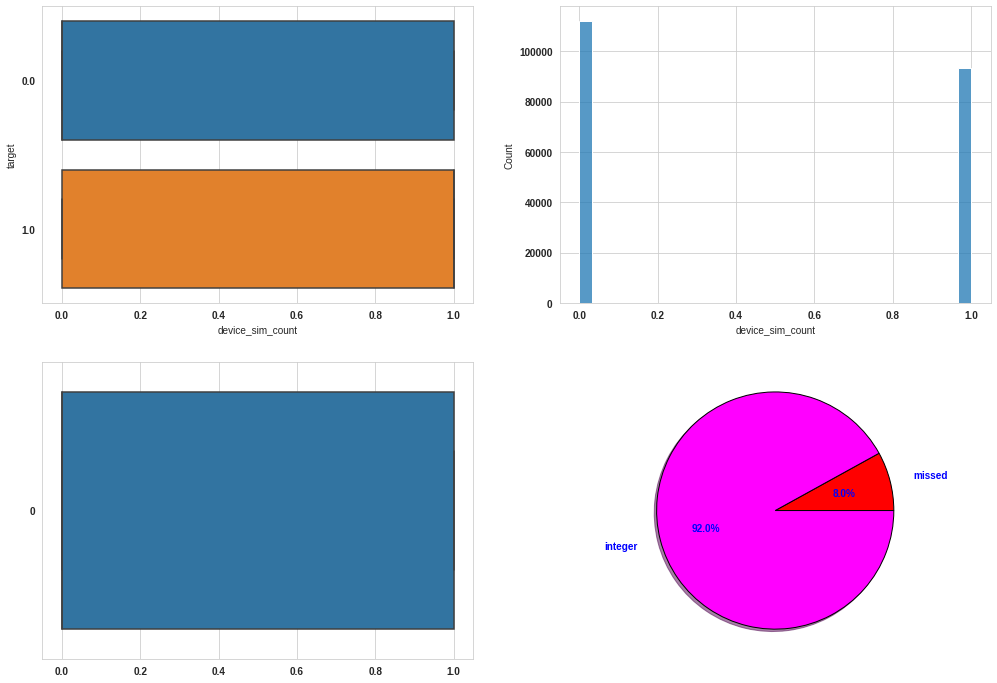

desc - Атрибут устройства - количество SIM-карт
type - float64
available_cnt - 189125
available_pct - 91.97568
missed_cnt - 16500
missed_pct - 8.02432
zero_cnt - 0
zero_pct - 0.0
int_cnt - 189125
int_pct - 100.0
unique - 3
max - 3.0
min - 1.0
median - 1.0
mean - 1.49428
mode - 1.0
skew - 0.0325
kurt - -1.97351
Корелюється з:
	1.0 - device_sim_count (Атрибут устройства - количество SIM-карт)
	0.58 - device_ios_version (Атрибут устройства - операционная система)
	-0.532 - device_android_version (Атрибут устройства - операционная система)
	-0.408 - cnt_sms_category_collect (Количество SMS из категории "Коллекторы")
	-0.361 - cnt_bank_sms_category_poltavaban (Количество SMS из категории "Банки": Полтавабанк)
	0.35 - entertainment (Обмен бонусов на подарки категории Развлечения)
	-0.277 - device_brand_apple (Атрибут устройства - бренд)
	0.265 - Food (Обмен бонусов на подарки категории Рестораны и Кафе)
	0.259 - device_brand_samsung (Атрибут устройства - бренд)
	-0.214 - device_price (Атрибу

<Figure size 432x288 with 0 Axes>

In [20]:
# Огляд метрик окремої фічі:
eda.show_feature_description('device_sim_count')

device_sim_count
(Атрибут устройства - количество SIM-карт)


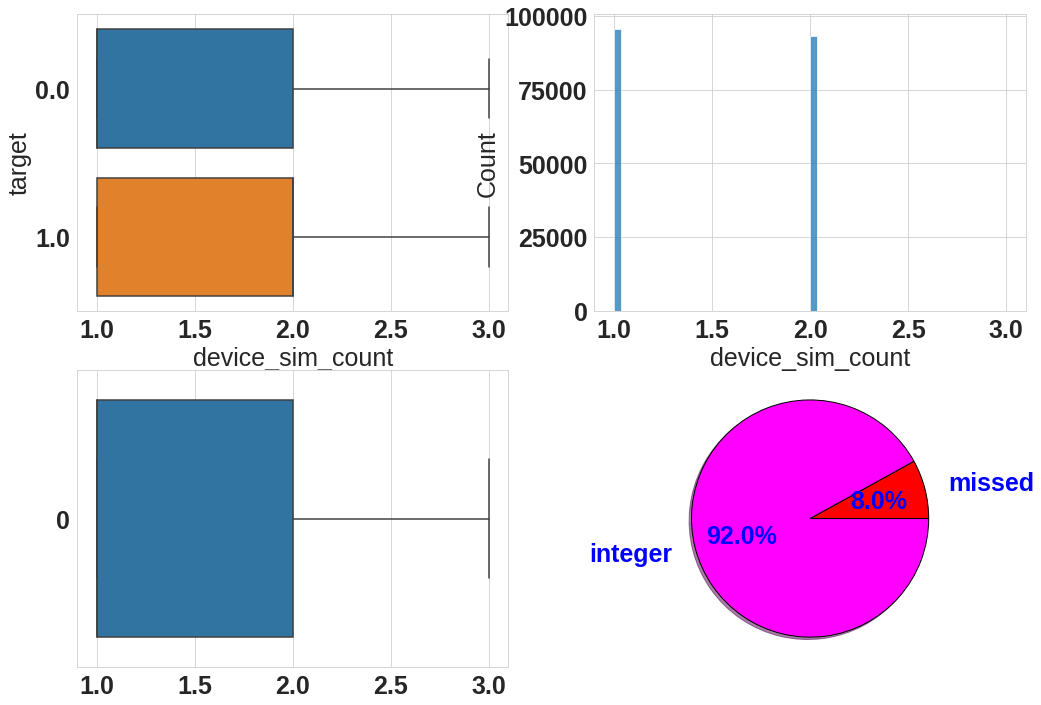

desc - Атрибут устройства - количество SIM-карт
type - float64
available_cnt - 189125
available_pct - 91.97568
missed_cnt - 16500
missed_pct - 8.02432
zero_cnt - 0
zero_pct - 0.0
int_cnt - 189125
int_pct - 100.0
unique - 3
max - 3.0
min - 1.0
median - 1.0
mean - 1.49428
mode - 1.0
skew - 0.0325
kurt - -1.97351
Корелюється з:
	1.0 - device_sim_count (Атрибут устройства - количество SIM-карт)
	0.58 - device_ios_version (Атрибут устройства - операционная система)
	-0.532 - device_android_version (Атрибут устройства - операционная система)
	-0.408 - cnt_sms_category_collect (Количество SMS из категории "Коллекторы")
	-0.361 - cnt_bank_sms_category_poltavaban (Количество SMS из категории "Банки": Полтавабанк)
	0.35 - entertainment (Обмен бонусов на подарки категории Развлечения)
	-0.277 - device_brand_apple (Атрибут устройства - бренд)
	0.265 - Food (Обмен бонусов на подарки категории Рестораны и Кафе)
	0.259 - device_brand_samsung (Атрибут устройства - бренд)
	-0.214 - device_price (Атрибу

<Figure size 432x288 with 0 Axes>

In [18]:
eda.show_feature_description('device_sim_count')

In [20]:
# Огляд таблиці з метриками усіх фіч
print('Підготовлені метрики: ')
for pos, metr in enumerate(eda.df_info.columns):
    print(f'\t{pos+1}. {metr}')

Підготовлені метрики: 
	1. name
	2. desc
	3. type
	4. available_cnt
	5. available_pct
	6. missed_cnt
	7. missed_pct
	8. zero_cnt
	9. zero_pct
	10. int_cnt
	11. int_pct
	12. unique
	13. max
	14. min
	15. median
	16. mean
	17. mode
	18. skew
	19. kurt


In [21]:
eda.df_info.set_index('name', inplace=False)

,desc,type,available_cnt,available_pct,missed_cnt,missed_pct,zero_cnt,zero_pct,int_cnt,int_pct,unique,max,min,median,mean,mode,skew,kurt
name,,,,,,,,,,,,,,,,,,
abon_id,Идентификатор Абонента,float64,205625,100.0000,0,0.0000,0,0.0000,205625,100.00,205625,1.888225e+06,1.000001e+06,1414984.000,1.425224e+06,1000001.000,0.093,-1.146
device_id,Идентификатор устройства,float64,205625,100.0000,0,0.0000,0,0.0000,205625,100.00,12680,1.150570e+05,1.000010e+05,109998.000,1.090586e+05,109995.000,-0.417,-1.213
target,Таргет,float64,49862,24.2490,0,0.0000,155763,75.7510,49862,100.00,2,1.000000e+00,0.000000e+00,0.000,2.420000e-01,0.000,1.202,-0.556
Balance_uah,Баланс,float64,204391,99.3999,1198,0.5826,36,0.0175,21,0.01,196644,1.672381e+15,-8.569925e+17,0.185,-1.742504e+13,0.001,-225.880,51047.096
TM_ID,Тариф,float64,204427,99.4174,1198,0.5826,0,0.0000,0,0.00,75,7.257000e+01,6.044200e+01,72.014,7.189900e+01,72.206,-4.880,63.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
device_type_tablet,Атрибут устройства - тип устройства,float64,75,0.0365,1299,0.6317,204251,99.3318,75,100.00,2,1.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000,52.167,2719.414
device_type_nan,Атрибут устройства - тип устройства,float64,15201,7.3926,1299,0.6317,189125,91.9757,15201,100.00,2,1.000000e+00,0.000000e+00,0.000,7.400000e-02,0.000,3.244,8.522
device_type_rus_other,Атрибут устройства - тип устройства,float64,189125,91.9757,1299,0.6317,15201,7.3926,189125,100.00,2,1.000000e+00,0.000000e+00,1.000,9.260000e-01,1.000,-3.244,8.522


In [22]:
# eda.df_info.to_excel(metrics_df.xlsx)

## Опрацювання основних таблиць train та test (без фічі координат)

In [ ]:
time_start = datetime.now()
eda.convert_train(config_file='metrics_df.xlsx')
print(f'{eda.df.shape[0]} records converted in {datetime.now()-time_start}')

In [ ]:
eda.df.to_pickle('df_train_main_converted_wo_spatial.pickle')

In [ ]:
df_test_main_wo_spatial = eda.convert_test(test_main_fe)
df_test_main_wo_spatial.drop(columns=['target'], inplace=True)
df_test_main_wo_spatial.to_pickle('df_test_main_converted_wo_spatial.pickle')

## Огляд та опрацювання датасету з відомостями про використання сервісів (b_num)

### Огляд

In [7]:
train_services.head(15)

,abon_id,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in
0,1000006.0,311,1.0,0.0,13.0,0.0,0.0,0.0
1,1000006.0,7104,0.0,0.0,0.0,0.0,2.0,2.0
2,1000006.0,dzvinok,0.0,0.0,0.0,0.0,0.0,1.0
3,1000006.0,pensfond,0.0,0.0,0.0,0.0,0.0,6.0
4,1000006.0,sumyoenerg,0.0,0.0,0.0,0.0,0.0,2.0
5,1000009.0,ukrgasbank,0.0,0.0,0.0,0.0,0.0,11.0
6,1000012.0,novaposhta,0.0,0.0,0.0,0.0,0.0,2.0
7,1000012.0,oschadbank,0.0,0.0,0.0,0.0,0.0,2.0
8,1000012.0,vkcom,0.0,0.0,0.0,0.0,0.0,1.0
9,1000015.0,kocmo,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
train_services.shape

(836780, 8)

In [9]:
train_services['bnum'].nunique()

16958

In [10]:
train_services['abon_id'].nunique()

169792

In [26]:
#train_services['bnum'].value_counts(sort=True).to_excel('services.xlsx')  # для ручного формування нових фіч
train_services['bnum'].value_counts(sort=True)

privatbank     46882
oschadbank     26470
novaposhta     24621
111            18481
facebook       12402
               ...  
poliakovlab        1
7ka                1
secretangel        1
odessa-auto        1
allmyphone         1
Name: bnum, Length: 16958, dtype: int64

In [31]:
train_services.dtypes

abon_id          int32
bnum            object
call_cnt_out     int16
call_cnt_in       int8
call_dur_out     int32
call_dur_in      int16
cnt_sms_out      int16
cnt_sms_in       int16
dtype: object

### Клас опрацювання (bnum)

In [57]:
class BnumFeatureHandler:
    # За ключовими словами виділено декілька додаткових категорій (18)
    bnum_cat = {'marginal':
                ["zvonmonet", "monetka", "7monet", "shvgroshi", "eurogroshi", "groshidozp", "egroshicom", "e groshi", "shv.groshi", "groshivsim", "daemogrosh", "groshman", "groshi doz", "groshiua", "groshik", "groshi dozp", "groshy", "megagroshi", "vashigrosh", "vashigroshi", "tvoigroshi", "groshi24", "groshi247", "egroshi", "daemogroshi", "tytgroshy", "svidkogrosh", "miloan.ua", "ccloan", "loanyua", "loan-credi", "megaloan", "loan-credit", "vloan", "moneygo", "moneyveo", "vip-money", "easy-money", "moneyboom", "money4me", "money4you", "sms2money", "money", "moneycredi", "moneyou", "gomoney", "stormoney", "moneycredit", "money24", "moneytop", "mrmoney", "globalmoney", "moneyu", "moneyexper", "moneyexpert", "moneypoint", "smartmoney", "automoney", "money_alg", "moneyto", "money club", "moneysend", "mr-money", "prostomoney", "moneymarke", "kredit-300", "kredobank", "kredit-3000", "newkrediti", "kredit", "kash kredi", "kredit vse", "kreditua", "kf-kredit", "kash kredit", "starkredit", "ukredit", "kredit vsem", "kredits24", "gokredit", "fastkredit", "kredytvamc", "kreditgo", "vashkredut", "debetkredi", "royalkredi", "kredit-24", "novikredit", "pvks-kredit", "kredytvamco", "kreditt", "kredit4u", "novikredyt", "novikrediti", "debetkredit", "kreditman", "royalkredit", "kredit 7", "kredit-0", "pvks-kredi", "kredit 365", "novikredyty", "kredityem", "kredit_m", "mykredit", "uakredit", "kreditka", "kredit_112", "kredenscafe", "kredit1", "hotkredit", "kreditonli", "kredytka", "kredo", "itkredobank", "kreditvsem", "kreditonlin", "creditplus", "creditkasa", "mycredit", "alexcredlt", "creditman", "creditexpr", "credit-0", "sloncredit", "credit7", "creditdnep", "alexcredit", "credit", "zecredit", "credit ua", "24credit", "creditcent", "soscredit", "credify", "creditcafe", "globalcred", "creditcentr", "credit.me", "globcredit", "creditup", "creditlite", "moneycredi", "litecredit", "microcredi", "credit24", "lime credi", "aiex credi", "goldcredit", "procredit", "forzacredi", "topcredit", "globalcredi", "top credit", "loan-credi", "credilo", "microcredit", "creditbot", "infocredit", "nicecredit", "creditnice", "moneycredit", "creditor", "forzacredit", "credit3000", "icredit", "creditdnepr", "ua-credit", "aiex credit", "lime credit", "credit-pro", "crediton", "credit2000", "creditbox", "bankcredit", "credit365", "loan-credit", "credy", "credit2u", "credit30000", "creditua", "mlcrocredi", "credit20000", "creditfree", "credit 0", "gutcreditu", "creditsmeu", "ua_credit", "o-credit", "supercredi", "creditik", "credit4you", "credmir", "credit10mi", "gutcreditua", "smartcredi", "aviracredi", "klt credit", "centrcredi", "supercredit", "creditlife", "creditcash", "sens credi", "oncredit", "credit25000", "catcredit", "credithelp", "creditpart", "megacredit", "creditsmeua", "credit10min", "creditorde", "cash credi", "credit deb", "credit2500", "monocredit", "aviracredit", "gogocredit", "centrcredit", "creditorder", "credit 2020", "micr0credi", "credit debt", "creditline", "credit clu", "credcenter", "cash credit", "cashcredit", "creditmone", "unicredit", "mlcrocredit", "credit fre", "uitracredit", "yescredit", "crediti", "1credit", "credit 202", "sens credit", "incredo", "cash-credi", "recredit", "exp credit", "credit0", "autocredo", "creditbank", "lombard 1", "lombard", "lombard zs", "bestlombar", "lombard gnp", "lomb.bazis", "lombard999", "lombard gn", "lombardspa", "lombsakura", "ilombard", "lombard ki", "bestlombard", "vashlombar", "lomb.parus", "lombgotivk", "evrolombar", "lomb-komod", "lombardreal", "lombardspas", "lombgotivka", "plomby gst", "lider lomb", "lombard zt", "lombardsbi", "pulombard", "lombard-ua", "garant lomb", "meb.lombar", "cash", "mistercash", "e-cash", "cashberry", "blago cash", "cashhelp", "verocash", "cash24", "cashup", "flashcash", "microcash", "casharing", "cashinsky", "cashme", "gdcashmere", "advcash", "cash247", "cashbox", "ultracashu", "creditcash", "cash credi", "cashyou", "cash2go", "ultracashua", "topcash", "allcash", "cashdeskmon", "hellocash", "cash credit", "cashcredit", "cashman", "cash4sms", "cash_games", "cashdeskmo", "yourcash", "fxcash", "cash-credi", "cashpro", "cashbelt.ua", "zaim", "zaim24-7", "zaim24", "zaimdozp", "fastzaim24", "bistrozaim", "leadszaim", "zaimpro", "izaime", "bystryjzaim", "shvidkozaim", "vashzaim", "vzaimi", "zaimvsem", "zaimi", "zaimiplus", "zaimo", "shvidk0zaim", "helpzaim", "ukrzaim", "ykr zaim", "cosmolot", "mikrozaym", "turbozaym", "zaymo", "zaymua", "zaymgrad", "ukrcollect", "collector", "fcollect", "dengi24/7", "dengi-24", "dengi_vdol", "denginakar", "dengi_vdolg", "dengi24", "goldengate", "denginakart", "dengi.com", "pozyka", "ukrpozyka", "biz-pozyka", "s.pozyka", "bizpozyka", "pozyka24", "pozykatut", "sim.pozyka", "tvojapozyk", "tvojapozyka"],
            'car_owner':
                ["wog", "socar", "dok", "brsm", "glusco", "club4x4", "upg", "okko", "exist.ua", "amic energy", "bmw", "bmw_idealm", "bmwfix", "bmwauto", "bmw lviv", "aria-bmw", "audi vipos", "ddaudio", "audi_odessa", "splaudio", "claudie", "mircaraudi", "claudia", "audicentre", "audi_odess", "caraudio", "audizp.com", "audiservice", "audi dnepr", "mircaraudio", "porsche", "volkswagen", "senseat", "hyundai", "carbot", "alfacars", "4mycar", "2car.com.ua", "winwincars", "mycar24", "2car.com.u", "caraudio", "carclip", "toyota", "toyota_cit", "toyotaluts", "toyota_city", "toyota st", "toyota nk", "toyotalutsk", "toyota lviv", "ford", "cto ford", "ford.pl.ua", "fordlvivua", "kia ukrain", "kia ukraine", "aptekiaks", "kiaparts", "kia kilceva", "kia kilcev", "benishgps", "ukrgps.net", "gps-plus", "vipgps.org", "benish gps", "lexus", "lexus kh", "lexus dnep", "mitsubishi", "nissan", "nissanpodo", "opel", "skoda auto", "skoda", "skodalutsk", "skodakreme"],
            'social':
                ["facebook", "google", "telegram", "tiktok", "microsoft", "whatsapp", "viber", "instagram", "ukrnet", "vkcom", "okru", "zoom"],
            'device_shop':
                ["eldorado", "foxtrot.ua", "comfy", "citrus.ua", "rozetka", "allo", "citrus", "mazilla ua", "hotline", "moyo.ua"],
            'clinic':
                ["e-health", "synevo", "dobrobut", "oxfordmed", "helsi", "dila"],
            'expens':
                ["dominos", "apple", "brocard", "glovo", "makeup", "metlife", "raketa", "sushi wok", "winetime", "luxoptica", "zolotiy vi"],
            'post':
                ["novaposhta", "ukrposhta", "meestua", "novapay"],
            'sport':
                ["megasport", "sportlife", "sportmaste", "sport-city", "sportmaster", "sportland", "sportbank", "megasportu", "sportlandia", "sportlandi", "urbansport", "intersport", "sport&spa", "sportfit", "sportstar", "deltasport", "zebrasport", "diromsport", "multisport", "terrasport", "sportclubx", "sportgoods", "instasport", "sport&moda", "delta sport", "sportshop", "sportmir", "svit sport", "sport havk", "sportstudi", "sportclub", "sofia-sport", "peak sport", "sport maga", "kid-sport", "sportlavka", "unisport", "sport-x", "sportpit_pl", "sport havka", "sportvida", "ligasporta", "sportcente", "sport_stil", "sport magaz", "mwsport", "sport city", "planetsport", "sportmarke", "sportobzor", "sportshots", "sportime", "sportextri", "kb-75sport", "sportextrim", "sport shop", "tviy sport", "ukrsportpit", "sportedu.o", "sportstudio", "sportbaza", "sport max", "semi sport", "sportpit_p", "sporthunte", "fansport", "sport star", "sportcar", "esportal", "sport cube", "rn-sport", "sportmax", "pro-sport", "sportinvent", "sportalm", "sportsale", "uasport", "waysport", "aktasport", "sport-atle", "rosport", "grand sport", "sporte", "arena sport", "sportmass", "sportactiv", "sport-stor", "volna-sport", "olimp sport", "osport.ua", "sportloto", "pir.sporta", "hop-sport", "sportplus", "sportwear", "ideal sport", "sportpit", "sportcenter", "energym", "i-gym", "pulse gym", "gym-rex", "everestgym", "ip gym", "gymbeam", "gymmaxx", "kotengym", "oxygym", "ladygym", "gymzelena20", "z gym", "eurogym", "atletgym", "militarygym", "megagym", "ekvator.gym", "olympia-gym", "gym oxford", "zeusgym&em", "gymfit", "top gym", "ultragym", "regym"],
            'house':
                ["volia", "contactgas", "triolan", "epicentrk", "vodokanal", "ukrtelecom", "gaz", "gazzbu", "viasat", "datagroup", "poltavagaz", "poltgazzbu", "gazpostavka", "poltgazzbut", "centrgazza", "centrgazzap"],
            'apteka':
                ["apteka911", "apteka tas", "apteka d.s.", "apteka d.s", "aptekar-", "aptekanetu", "apteka nc", "apteka", "aptekar", "apteka24.u", "nashaapteka", "aptekizpua", "apteka 36_", "geoapteka", "apteka_anc", "apteka24", "aptekazaka", "aptekanetua", "apteka24.ua", "aptekiaks", "apteka lif", "aptekazakaz", "apteka rua", "sapteka", "apteka 36.", "mega-aptek", "apteka.led", "apteka plu", "apteka plus", "fit0apteka", "fitoapteka", "avtoapteka", "apteka36i6", "lizalaptev", "apteka 7-y", "my apteka", "lizalapteva", "apteka life"],
            'mall':
                ["prostor", "varus", "chervonyi", "shop zakaz", "eva", "humana", "nova_linia", "intertop", "avon", "watsonsclu", "miraton", "jysk", "arber", "md fashion", "gloriajeans", "watsonsclub", "reserved", "adidas", "pazolini", "colins", "auchan", "columbia", "secunda", "yakaboo.ua", "auchan", "vitto rossi", "oodji", "fora"],
            'habits':
                ["morepiva", "more piva", "pivasov", "dom piva", "pivarium", "pivoplus", "pivobank", "pivobar", "nashe pivo", "pivoteka", "alcomag", "alcoparty", "alcopro", "alcotown", "alcofansho", "alcofanshop", "maxbeer", "beermarket", "vybeer", "vybeerai", "goldbeer", "beerline", "beerlander", "beerwine", "homebeer", "my-beer", "kriss beer", "beer.live", "thebeersho", "beerhouse", "varvar.beer", "beer&blues"],
            'young':
                ["tinder", "steam", "speak up", "wargaming", "game", "gaming", "snapchat", "discord", "badoo", "airbnb", "yakaboo", "spot-game", "game-shop", "egame", "4game", "x-game", "mygames", "game zone", "gamecore v", "upgames", "gamecore vr", "questgameu", "questgameua", "igame", "cbgames", "offgamers", "the game", "sharegameme", "sharegamem", "gamestore", "gamenet", "gamepad"],
            'security':
                ["ohrana.ua", "centrohrana", "liderohrana", "mun_ohrana", "vashaohrana", "vashaohran", "venbest", "a1 securit", "security", "a1 security", "secur", "secur.ua", "mccsecurit", "skysecurit", "pdp-secur", "bestsecur", "security-s", "mccsecurity", "ibmsecurit", "ajax", "sheriff", "sirius"],
            'pets':
                ["masterzoo", "zootovary", "zoocomplex", "e-zoo", "ezoo", "zoo-jungle", "eurozoo", "zooapteka", "zoolux", "zoolandia", "zoovet", "zoostar", "zoomark", "zoomagazin", "zoohelper", "zooera", "zooplus", "zoodom", "zoostyle", "zoogurman", "zoocool", "zoomir", "paintzoom", "ukrzoovetp", "zoomag", "zoopitomec"],
            'work_board':
                ["rabota.ua", "rabotalab", "estrabota", "rabota", "work.ua", "razem.work", "work in lc", "studwork", "norma-work", "smart work"],
            'baby':
                ["antoshka", "baby", "mother", "child", "kiddex", "justkids_u", "kids repub", "kiwi kids", "kidstaff", "evgakids", "bestkids", "klevokids", "kids club", "fashionkid", "justkids_ua", "kidsstore", "superskidk", "milkkids", "kid-sport", "kids republ", "kidauto", "kids", "kidr.com.u", "kidbutik.u", "fashionkids", "maris.kid", "oki-kids", "kiddy land", "kidtown", "kidslook", "kiditop", "kidbutik.ua", "ni-kids", "kiddyboom", "everykid", "a.kid", "happykids", "kmkids", "dg kids"],
            'pay_sys':
                ["paypal", "sharpay", "payoneer", "easypay", "papaya", "ipay.ua", "koronapay", "paysend.co", "paysend.com", "way for pay", "paycell", "alipay", "elpaysys", "dg payment", "paysera", "ua-pay", "epayments", "electropay", "payeer.com", "pay ukraine", "pay ukrain", "elupay", "pay vn ua", "paylink", "payukraine", "payalnik", "citypay", "vladpay", "wikipays", "b4bpayment", "paysend", "mpay", "payphone x", "skpay karta", "actionpay", "cardpay", "paytomat"]}


    def __init__(self):
        self.cols_total = ['abon_id', 'unique_bnum', 'total_call_cnt_out', 'total_call_cnt_in', 'total_call_dur_out', 'total_call_dur_in', 'total_cnt_sms_out', 'total_cnt_sms_in']
        self.cols_by_cat = ['_cat_present', '_unique_services', '_call_cnt_out', '_call_cnt_in', '_call_dur_out', '_call_dur_in', '_cnt_sms_out', '_cnt_sms_in']

        for cat_name in self.bnum_cat.keys():
            for suffix in self.cols_by_cat:
                self.cols_total.append(cat_name+suffix)

    def convert_services(self, input_df: pd.DataFrame):
        services_df = input_df.copy(deep=True)
        abons = services_df['abon_id'].unique().tolist()
        service_feature_data = []
        for abon in abons:
            abon_df_part = services_df.loc[services_df['abon_id'] == abon].drop(columns=['abon_id'])
            abon_data_row = []
            abon_data_row.append(abon)
            abon_data_row.append(abon_df_part['bnum'].nunique())
            abon_data_row.append(abon_df_part['call_cnt_out'].sum())
            abon_data_row.append(abon_df_part['call_cnt_in'].sum())
            abon_data_row.append(abon_df_part['call_dur_out'].sum())
            abon_data_row.append(abon_df_part['call_dur_in'].sum())
            abon_data_row.append(abon_df_part['cnt_sms_out'].sum())
            abon_data_row.append(abon_df_part['cnt_sms_in'].sum())
            for cat in self.bnum_cat.keys():
                cat_temp_df = abon_df_part.loc[abon_df_part['bnum'].isin(self.bnum_cat[cat])]
                if cat_temp_df.shape[0] > 0:
                    abon_data_row.append(1)
                else:
                    abon_data_row.append(0)
                abon_data_row.append(cat_temp_df['bnum'].nunique())
                abon_data_row.append(cat_temp_df['call_cnt_out'].sum())
                abon_data_row.append(cat_temp_df['call_cnt_in'].sum())
                abon_data_row.append(cat_temp_df['call_dur_out'].sum())
                abon_data_row.append(cat_temp_df['call_dur_in'].sum())
                abon_data_row.append(cat_temp_df['cnt_sms_out'].sum())
                abon_data_row.append(cat_temp_df['cnt_sms_in'].sum())
            service_feature_data.append(abon_data_row)

        service_feature_df = pd.DataFrame(data=service_feature_data, columns=self.cols_total)
        service_feature_df.set_index('abon_id', inplace=True, drop=True)
        return service_feature_df

In [58]:
service_feature_handler = BnumFeatureHandler()

### Опрацювання Train (bnum)

In [59]:
df_converted_train_services = service_feature_handler.convert_services(train_services)

In [63]:
# Виправлення деяких помилок класу (спрощення типів, визначення колонок, у яких відсутні дані)
df_converted_train_services.index = pd.to_numeric(df_converted_train_services.index, downcast='integer')
for col in df_converted_train_services.columns:
    df_converted_train_services[col] = pd.to_numeric(df_converted_train_services[col], downcast='integer')

In [65]:
serv_count = df_converted_train_services.replace([0], np.nan).count()
zero_cols_serv = serv_count.loc[serv_count == 0].index.tolist()

In [66]:
len(zero_cols_serv)

90

In [67]:
df_converted_train_services.drop(columns=zero_cols_serv, inplace=True)
df_converted_train_services.fillna(0, inplace=True)
df_converted_train_services.head(35)

,unique_bnum,total_call_cnt_out,total_call_cnt_in,total_call_dur_out,total_call_dur_in,total_cnt_sms_out,total_cnt_sms_in,marginal_cat_present,marginal_unique_services,marginal_cnt_sms_in,...,pets_cnt_sms_in,work_board_cat_present,work_board_unique_services,work_board_cnt_sms_in,baby_cat_present,baby_unique_services,baby_cnt_sms_in,pay_sys_cat_present,pay_sys_unique_services,pay_sys_cnt_sms_in
abon_id,,,,,,,,,,,,,,,,,,,,,
1000006,5,1,0,13,0,2,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000009,1,0,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000012,3,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000015,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000020,2,0,0,0,0,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000021,3,1,0,12,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000024,2,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000025,3,0,0,0,0,0,31,1,1,24,...,0,0,0,0,0,0,0,0,0,0
1000030,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
df_converted_train_services.to_pickle('df_train_service_new_features.pickle')

### Опрацювання Test (bnum)

In [69]:
df_converted_test_services = service_feature_handler.convert_services(test_services)

In [70]:
df_converted_test_services.index = pd.to_numeric(df_converted_test_services.index, downcast='integer')
for col in df_converted_test_services.columns:
    df_converted_test_services[col] = pd.to_numeric(df_converted_test_services[col], downcast='integer')

In [72]:
df_converted_test_services.drop(columns=zero_cols_serv, inplace=True)
df_converted_test_services.fillna(0, inplace=True)
df_converted_test_services.head(35)

,unique_bnum,total_call_cnt_out,total_call_cnt_in,total_call_dur_out,total_call_dur_in,total_cnt_sms_out,total_cnt_sms_in,marginal_cat_present,marginal_unique_services,marginal_cnt_sms_in,...,pets_cnt_sms_in,work_board_cat_present,work_board_unique_services,work_board_cnt_sms_in,baby_cat_present,baby_unique_services,baby_cnt_sms_in,pay_sys_cat_present,pay_sys_unique_services,pay_sys_cnt_sms_in
abon_id,,,,,,,,,,,,,,,,,,,,,
1000003,2,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000007,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000023,2,0,0,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000026,2,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000027,2,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000032,6,0,0,0,0,25,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000035,3,0,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000036,1,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000037,2,9,0,62,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df_converted_test_services.to_pickle('df_test_service_new_features.pickle')

# Огляд та опрацювання датафрейму з відомостіями про використані додатки (apps)

### Огляд

In [11]:
train_apps.head(10)

,abon_id,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt
0,1000009.0,17.0,2.0,2.41,8.0,3.0
1,1000009.0,232.0,1749.0,2190.77,146.0,5.0
2,1000009.0,246.0,2997.0,1397.89,102.0,4.0
3,1000009.0,249.0,694.0,52.67,30.0,4.0
4,1000009.0,250.0,12268.0,11305.78,552.0,4.0
5,1000009.0,373.0,4567.0,343726.29,1665.0,5.0
6,1000009.0,538.0,1392.0,538.50,125.0,5.0
7,1000009.0,580.0,28.0,5.72,6.0,1.0
8,1000009.0,590.0,113.0,405.25,1898.0,8.0
9,1000009.0,596.0,0.0,0.60,4.0,1.0


In [12]:
train_apps.shape

(6647895, 6)

In [13]:
train_apps['abon_id'].nunique()

140830

In [14]:
train_apps['Application'].nunique()

719

In [40]:
train_apps.dtypes

abon_id                float64
Application            float64
SUM_of_Duration_sec    float64
SUM_of_Volume_kb       float64
SUM_of_Count_events    float64
MAX_of_day_cnt         float64
dtype: object

In [41]:
for col in train_apps.columns:
    train_apps[col] = pd.to_numeric(round(train_apps[col]), downcast='integer')
train_apps.dtypes

abon_id                int32
Application            int16
SUM_of_Duration_sec    int32
SUM_of_Volume_kb       int32
SUM_of_Count_events    int32
MAX_of_day_cnt          int8
dtype: object

In [42]:
abons = train_apps['abon_id'].unique().tolist()
len(abons)

140830

In [43]:
apps = train_apps['Application'].unique().tolist()
len(apps)

719

### Клас опрацювання Application

In [38]:
class AppsFeatureHandler:
    res_features_list = {"806_sum_cnt_events", "806_sum_duration_sec", "806_sum_vol_kb", "889_sum_duration_sec", "1023_max_day_cnt", "246_sum_vol_kb", "876_sum_duration_sec", "889_sum_vol_kb", "max_mean_day", "869_sum_cnt_events", "596_sum_cnt_events", "1345_sum_vol_kb", "249_sum_duration_sec", "807_max_day_cnt", "1357_max_day_cnt", "249_sum_cnt_events", "889_sum_cnt_events", "824_sum_vol_kb", "1347_sum_duration_sec", "669_max_day_cnt", "1345_sum_cnt_events", "232_sum_vol_kb", "670_sum_duration_sec", "249_sum_vol_kb", "580_sum_duration_sec", "670_sum_vol_kb", "232_sum_duration_sec", "1345_sum_duration_sec", "842_sum_duration_sec", "1411_max_day_cnt", "373_sum_duration_sec", "670_sum_cnt_events", "580_sum_cnt_events", "246_sum_duration_sec", "824_sum_duration_sec", "1863_sum_duration_sec", "232_sum_cnt_events", "869_sum_vol_kb", "682_sum_cnt_events", "708_sum_vol_kb", "824_sum_cnt_events", "580_sum_vol_kb", "669_sum_vol_kb", "sum_duration_apps", "689_sum_duration_sec", "590_sum_duration_sec", "1411_sum_cnt_events", "708_sum_duration_sec", "669_sum_duration_sec", "250_sum_duration_sec", "769_sum_duration_sec", "842_sum_vol_kb", "836_sum_vol_kb", "1367_max_day_cnt", "836_sum_cnt_events", "1365_sum_duration_sec", "266_max_day_cnt", "682_sum_vol_kb", "250_sum_vol_kb", "708_sum_cnt_events", "apps_unique", "682_sum_duration_sec", "876_max_day_cnt", "246_sum_cnt_events", "373_sum_cnt_events", "sum_vol_kb_apps", "1406_sum_duration_sec", "1406_sum_cnt_events", "842_sum_cnt_events", "669_sum_cnt_events", "538_sum_cnt_events", "250_sum_cnt_events", "538_sum_vol_kb", "1412_max_day_cnt", "869_sum_duration_sec", "249_max_day_cnt", "580_max_day_cnt", "1111_max_day_cnt", "538_sum_duration_sec", "800_max_day_cnt", "373_sum_vol_kb", "836_max_day_cnt", "sum_of_cnt_events_apps", "1365_sum_vol_kb", "839_max_day_cnt", "250_max_day_cnt", "1464_sum_cnt_events", "806_max_day_cnt", "590_sum_cnt_events", "826_max_day_cnt", "1365_sum_cnt_events", "590_sum_vol_kb", "889_max_day_cnt", "1464_max_day_cnt", "1023_app_present", "1406_max_day_cnt", "1457_max_day_cnt", "722_max_day_cnt", "15_max_day_cnt", "1127_max_day_cnt", "782_max_day_cnt", "940_max_day_cnt", "1476_max_day_cnt", "703_max_day_cnt", "1357_app_present", "1893_max_day_cnt", "1490_max_day_cnt", "803_max_day_cnt", "1412_app_present", "1111_app_present", "782_app_present", "675_max_day_cnt", "1459_max_day_cnt", "1127_app_present", "697_sum_cnt_events", "876_app_present", "812_max_day_cnt", "1476_app_present", "901_sum_cnt_events", "812_app_present", "307_app_present", "697_max_day_cnt", "1459_app_present", "1490_app_present", "889_app_present", "904_max_day_cnt", "803_app_present"}
    apps_to_convert = {15, 232, 246, 249, 250, 266, 307, 373, 538, 580, 590, 596, 669, 670, 675, 682, 689, 697, 703, 708, 722, 769, 782, 800, 803, 806, 807, 812, 824, 826, 836, 839, 842, 869, 876, 889, 901, 904, 940, 1023, 1111, 1127, 1345, 1347, 1357, 1365, 1367, 1406, 1411, 1412, 1457, 1459, 1464, 1476, 1490, 1863, 1893}

    cols_total_apps = ['abon_id','apps_unique','sum_duration_apps','sum_vol_kb_apps','sum_of_cnt_events_apps', 'max_mean_day']
    cols_by_app = ['_app_present', '_sum_duration_sec', '_sum_vol_kb', '_sum_cnt_events', '_max_day_cnt']


    def __init__(self, feature_list=None):
        """
        Якщо зміниться перелік фіч (наприклад їх планується більше), можна передати список

        :param feature_list: список вихідних фіч(найменувань колонок, які очікуються у вихідному датафреймі) потрібно враховувати побудову назви фічі прийнятою у класі (prepare_apps_feaures())
        """
        if feature_list is not None:
            self.res_features_list = feature_list  # фічі, які мають бути у вихідному датафреймі
            features_splited = []

            # для більш швидкого опрацювання визначаються лише ті додатки, які потрібні для вихідного датафрейму
            for f in feature_list:
                features_splited += f.split('_')
            numbers_in_features = [x for x in features_splited if x.isdigit()]
            self.apps_to_convert = set(numbers_in_features)

        self.headers_apps = []
        self.headers_apps += self.cols_total_apps
        for app in self.apps_to_convert:
            for metr in self.cols_by_app:
                self.headers_apps += [str(app)+metr]

    def prepare_apps_feaures(self, df_apps: pd.DataFrame) -> pd.DataFrame:
        """
        Підготовка фіч використання додатків: з загальної таблиці фактів використання додатків абонентами форматує новий датасет з унікальністю запису відповідно ідентифікатора абонента (відомості про кожен окремий додаток формуються додатковими стовпчиками.
        :param df_apps: датафрейм з відомостями про використання додатків
        :return: датафрейм з показниками по абонентам (індекс - ід абонента для подальшого джоіну
        """
        df_apps = df_apps.copy(deep=True)
        for col in df_apps.columns:
            df_apps[col] = pd.to_numeric(df_apps[col], downcast='integer')

        apps_data = []
        abons = df_apps['abon_id'].unique().tolist()

        for pos, abon in enumerate(abons):
            if pos%1000 == 0:
                print(round((pos/len(abons))*100, 2), " %")
            abon_df_part = df_apps.loc[df_apps['abon_id'] == abon].drop(columns=['abon_id'])
            abon_data_row = []
            abon_data_row.append(abon)
            abon_data_row.append(abon_df_part['Application'].nunique())
            abon_data_row.append(abon_df_part['SUM_of_Duration_sec'].sum())
            abon_data_row.append(abon_df_part['SUM_of_Volume_kb'].sum())
            abon_data_row.append(abon_df_part['SUM_of_Count_events'].sum())
            abon_data_row.append(abon_df_part['MAX_of_day_cnt'].mean())

            df_grouped_apps = abon_df_part.groupby(by='Application').sum()
            for app in self.apps_to_convert:
                if app in df_grouped_apps.index:
                    abon_data_row.append(1)
                    abon_data_row.append(df_grouped_apps.loc[app]['SUM_of_Duration_sec'])
                    abon_data_row.append(df_grouped_apps.loc[app]['SUM_of_Volume_kb'])
                    abon_data_row.append(df_grouped_apps.loc[app]['SUM_of_Count_events'])
                    abon_data_row.append(df_grouped_apps.loc[app]['MAX_of_day_cnt'])
                else:
                    abon_data_row.append(0)
                    abon_data_row.append(0)
                    abon_data_row.append(0)
                    abon_data_row.append(0)
                    abon_data_row.append(0)

            apps_data.append(abon_data_row)

        apps_feature_df = pd.DataFrame(data=apps_data, columns=self.headers_apps)
        return apps_feature_df

### Опрацювання Train (apps)

In [39]:
apps_handler = AppsFeatureHandler()

In [40]:
df_train_apps_features = apps_handler.prepare_apps_feaures(train_apps)

0.0  %
0.71  %
1.42  %
2.13  %
2.84  %
3.55  %
4.26  %
4.97  %
5.68  %
6.39  %
7.1  %
7.81  %
8.52  %
9.23  %
9.94  %
10.65  %
11.36  %
12.07  %
12.78  %
13.49  %
14.2  %
14.91  %
15.62  %
16.33  %
17.04  %
17.75  %
18.46  %
19.17  %
19.88  %
20.59  %
21.3  %
22.01  %
22.72  %
23.43  %
24.14  %
24.85  %
25.56  %
26.27  %
26.98  %
27.69  %
28.4  %
29.11  %
29.82  %
30.53  %
31.24  %
31.95  %
32.66  %
33.37  %
34.08  %
34.79  %
35.5  %
36.21  %
36.92  %
37.63  %
38.34  %
39.05  %
39.76  %
40.47  %
41.18  %
41.89  %
42.6  %
43.31  %
44.02  %
44.73  %
45.44  %
46.15  %
46.87  %
47.58  %
48.29  %
49.0  %
49.71  %
50.42  %
51.13  %
51.84  %
52.55  %
53.26  %
53.97  %
54.68  %
55.39  %
56.1  %
56.81  %
57.52  %
58.23  %
58.94  %
59.65  %
60.36  %
61.07  %
61.78  %
62.49  %
63.2  %
63.91  %
64.62  %
65.33  %
66.04  %
66.75  %
67.46  %
68.17  %
68.88  %
69.59  %
70.3  %
71.01  %
71.72  %
72.43  %
73.14  %
73.85  %
74.56  %
75.27  %
75.98  %
76.69  %
77.4  %
78.11  %
78.82  %
79.53  %
80.24  %
8

In [41]:
df_train_apps_features.set_index('abon_id', inplace=True, drop=True)

In [42]:
df_train_apps_features.head()

,apps_unique,sum_duration_apps,sum_vol_kb_apps,sum_of_cnt_events_apps,max_mean_day,769_app_present,769_sum_duration_sec,769_sum_vol_kb,769_sum_cnt_events,769_max_day_cnt,...,1406_app_present,1406_sum_duration_sec,1406_sum_vol_kb,1406_sum_cnt_events,1406_max_day_cnt,1023_app_present,1023_sum_duration_sec,1023_sum_vol_kb,1023_sum_cnt_events,1023_max_day_cnt
abon_id,,,,,,,,,,,,,,,,,,,,,
1000009,34,75176,468046.39,8280,3.735294,1,217.0,254.49,26.0,4.0,...,0,0.0,0.00,0.0,0.0,1,6.0,101.99,7.0,4.0
1000012,37,136466,255362.46,11808,7.243243,1,10.0,424.15,39.0,7.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1000015,50,265303,1066408.44,16498,5.640000,1,0.0,12.42,1.0,1.0,...,1,28385.0,152084.95,797.0,4.0,1,2.0,26.35,2.0,1.0
1000016,4,165,58.64,107,3.000000,0,0.0,0.00,0.0,0.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1000020,54,440335,1225026.32,34825,4.537037,1,82.0,2132.59,63.0,8.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0


In [43]:
df_train_apps_features.to_pickle('df_train_apps_new_features.pickle')

### Опрацювання Test (apps)

In [44]:
df_test_apps_features = apps_handler.prepare_apps_feaures(test_apps)

0.0  %
0.87  %
1.73  %
2.6  %
3.47  %
4.33  %
5.2  %
6.07  %
6.93  %
7.8  %
8.67  %
9.53  %
10.4  %
11.27  %
12.14  %
13.0  %
13.87  %
14.74  %
15.6  %
16.47  %
17.34  %
18.2  %
19.07  %
19.94  %
20.8  %
21.67  %
22.54  %
23.4  %
24.27  %
25.14  %
26.0  %
26.87  %
27.74  %
28.6  %
29.47  %
30.34  %
31.21  %
32.07  %
32.94  %
33.81  %
34.67  %
35.54  %
36.41  %
37.27  %
38.14  %
39.01  %
39.87  %
40.74  %
41.61  %
42.47  %
43.34  %
44.21  %
45.07  %
45.94  %
46.81  %
47.67  %
48.54  %
49.41  %
50.28  %
51.14  %
52.01  %
52.88  %
53.74  %
54.61  %
55.48  %
56.34  %
57.21  %
58.08  %
58.94  %
59.81  %
60.68  %
61.54  %
62.41  %
63.28  %
64.14  %
65.01  %
65.88  %
66.74  %
67.61  %
68.48  %
69.35  %
70.21  %
71.08  %
71.95  %
72.81  %
73.68  %
74.55  %
75.41  %
76.28  %
77.15  %
78.01  %
78.88  %
79.75  %
80.61  %
81.48  %
82.35  %
83.21  %
84.08  %
84.95  %
85.81  %
86.68  %
87.55  %
88.42  %
89.28  %
90.15  %
91.02  %
91.88  %
92.75  %
93.62  %
94.48  %
95.35  %
96.22  %
97.08  %
97.95  

In [45]:
df_test_apps_features.set_index('abon_id', inplace=True, drop=True)

In [48]:
df_test_apps_features.head(30)

,apps_unique,sum_duration_apps,sum_vol_kb_apps,sum_of_cnt_events_apps,max_mean_day,769_app_present,769_sum_duration_sec,769_sum_vol_kb,769_sum_cnt_events,769_max_day_cnt,...,1406_app_present,1406_sum_duration_sec,1406_sum_vol_kb,1406_sum_cnt_events,1406_max_day_cnt,1023_app_present,1023_sum_duration_sec,1023_sum_vol_kb,1023_sum_cnt_events,1023_max_day_cnt
abon_id,,,,,,,,,,,,,,,,,,,,,
1000023,41,314014,2480347.73,21713,7.121951,1,59.0,3907.46,41.0,9.0,...,1,0.0,3.62,1.0,1.0,0,0.0,0.00,0.0,0.0
1000026,73,2006861,4387456.83,207578,15.136986,1,2922.0,159912.67,3148.0,30.0,...,0,0.0,0.00,0.0,0.0,1,1.0,15.73,2.0,1.0
1000027,47,497786,1190688.60,60009,14.787234,1,576.0,10050.23,417.0,26.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1000032,42,403237,3567840.39,40043,7.190476,1,1216.0,3837.10,106.0,12.0,...,0,0.0,0.00,0.0,0.0,1,2.0,13.62,2.0,1.0
1000036,5,87,17.03,42,1.600000,0,0.0,0.00,0.0,0.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0
1000057,57,351517,2418892.78,38247,5.263158,1,322.0,10543.90,215.0,9.0,...,0,0.0,0.00,0.0,0.0,1,1.0,13.37,2.0,1.0
1000060,57,2529465,4871598.21,283759,16.842105,1,784.0,29716.37,440.0,27.0,...,1,694.0,18449.08,21.0,1.0,0,0.0,0.00,0.0,0.0
1000070,65,3555429,36101233.39,288901,15.369231,1,3278.0,93506.06,1635.0,31.0,...,1,22.0,7.87,1.0,1.0,1,196.0,1170.35,102.0,28.0
1000071,38,558161,378475.94,52107,19.078947,1,2532.0,2595.10,227.0,31.0,...,0,0.0,0.00,0.0,0.0,0,0.0,0.00,0.0,0.0


In [47]:
df_test_apps_features.to_pickle('df_test_apps_new_features.pickle')

### Попередні опрацювання - вибірка переліку додатків, які мають значення (кореляція та важливі фічі рандом форесту) - результат доданий до класу опрацювання

In [66]:
apps_feature_df = pd.read_pickle('new_apps_features.pickle')

In [47]:
apps_feature_df = pd.read_pickle('new_apps_features.pickle')

In [6]:
apps_feature_df.set_index('abon_id', drop=False, inplace=True)

In [7]:
apps_feature_df.head(5)

,abon_id,apps_unique,sum_duration_apps,sum_vol_kb_apps,sum_of_cnt_events_apps,max_mean_day,17_app_present,17_sum_duration_sec,17_sum_vol_kb,17_sum_cnt_events,...,894_app_present,894_sum_duration_sec,894_sum_vol_kb,894_sum_cnt_events,894_max_day_cnt,1132_app_present,1132_sum_duration_sec,1132_sum_vol_kb,1132_sum_cnt_events,1132_max_day_cnt
abon_id,,,,,,,,,,,,,,,,,,,,,
1000009,1000009,34,75176,468047,8280,3.735294,1,2,2,8,...,0,0,0,0,0,0,0,0,0,0
1000012,1000012,37,136466,255361,11808,7.243243,1,3,3,9,...,0,0,0,0,0,0,0,0,0,0
1000015,1000015,50,265303,1066403,16498,5.640000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1000016,1000016,4,165,59,107,3.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000020,1000020,54,440335,1225030,34825,4.537037,1,7,7,11,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_train_temp = train_main_fe.loc[:][['abon_id', 'target']]

In [9]:
y_train_temp['target'] = pd.to_numeric(y_train_temp['target'], downcast='integer')
y_train_temp['abon_id'] = pd.to_numeric(y_train_temp['abon_id'], downcast='integer')
y_train_temp.set_index('abon_id', drop=True, inplace=True)
y_train_temp

,target
abon_id,
1215806,0
1215139,0
1236635,0
1205230,0
1019270,0
...,...
1229807,0
1441477,0
1446209,0


In [10]:
apps_feature_df_w_target = apps_feature_df.join(y_train_temp, how='left')

In [11]:
apps_feature_df_w_target['target'].isnull().sum()

0

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=30)
clf.fit(apps_feature_df_w_target.drop(columns=['target']), apps_feature_df_w_target['target'])

RandomForestClassifier(n_estimators=500, n_jobs=30)

In [29]:
imp_vals = clf.feature_importances_

In [38]:
imp_names = apps_feature_df_w_target.drop(columns=['target']).columns.tolist()
impot_fea = pd.Series(index=list(imp_names), data=imp_vals)
impot_fea

abon_id                   1.542030e-02
apps_unique               4.924587e-03
sum_duration_apps         8.161747e-03
sum_vol_kb_apps           7.013348e-03
sum_of_cnt_events_apps    7.191081e-03
                              ...     
1132_app_present          0.000000e+00
1132_sum_duration_sec     0.000000e+00
1132_sum_vol_kb           0.000000e+00
1132_sum_cnt_events       3.744302e-08
1132_max_day_cnt          4.992679e-08
Length: 3601, dtype: float64

In [49]:
high_imp_list = impot_fea.loc[impot_fea > 0.0033].index.tolist()

In [25]:
temp_corr_mtx = apps_feature_df_w_target.corrwith(apps_feature_df_w_target['target'], axis=0)

abon_id                   0.047744
apps_unique               0.006195
sum_duration_apps         0.037300
sum_vol_kb_apps           0.024853
sum_of_cnt_events_apps    0.028926
                            ...   
1132_sum_duration_sec    -0.001559
1132_sum_vol_kb          -0.001559
1132_sum_cnt_events      -0.001559
1132_max_day_cnt         -0.001559
target                    1.000000
Length: 3602, dtype: float64

In [42]:
temp_corr_mtx_abs = np.abs(temp_corr_mtx)
temp_corr_mtx_abs

abon_id                   0.047744
apps_unique               0.006195
sum_duration_apps         0.037300
sum_vol_kb_apps           0.024853
sum_of_cnt_events_apps    0.028926
                            ...   
1132_sum_duration_sec     0.001559
1132_sum_vol_kb           0.001559
1132_sum_cnt_events       0.001559
1132_max_day_cnt          0.001559
target                    1.000000
Length: 3602, dtype: float64

In [59]:
high_target_list = temp_corr_mtx_abs.loc[temp_corr_mtx_abs > 0.02].index.tolist()

In [64]:
apps_selected_colnames = set(high_target_list).union(set(high_imp_list))
apps_selected_colnames = apps_selected_colnames - {'abon_id', 'target'}
len(apps_selected_colnames)

138

In [70]:
apps_selected_colnames

{'1023_app_present',
 '1023_max_day_cnt',
 '1111_app_present',
 '1111_max_day_cnt',
 '1127_app_present',
 '1127_max_day_cnt',
 '1280_app_present',
 '1345_sum_cnt_events',
 '1345_sum_duration_sec',
 '1345_sum_vol_kb',
 '1347_sum_duration_sec',
 '1357_app_present',
 '1357_max_day_cnt',
 '1365_sum_cnt_events',
 '1365_sum_duration_sec',
 '1365_sum_vol_kb',
 '1367_max_day_cnt',
 '1406_app_present',
 '1406_max_day_cnt',
 '1406_sum_cnt_events',
 '1406_sum_duration_sec',
 '1411_max_day_cnt',
 '1411_sum_cnt_events',
 '1412_app_present',
 '1412_max_day_cnt',
 '1413_app_present',
 '1457_max_day_cnt',
 '1459_app_present',
 '1459_max_day_cnt',
 '1464_max_day_cnt',
 '1464_sum_cnt_events',
 '1476_app_present',
 '1476_max_day_cnt',
 '1490_app_present',
 '1490_max_day_cnt',
 '15_max_day_cnt',
 '1863_sum_duration_sec',
 '1893_app_present',
 '1893_max_day_cnt',
 '232_sum_cnt_events',
 '232_sum_duration_sec',
 '232_sum_vol_kb',
 '246_sum_cnt_events',
 '246_sum_duration_sec',
 '246_sum_vol_kb',
 '249_max_d

In [ ]:
apps_selected_colnames = {'1023_app_present',
 '1023_max_day_cnt',
 '1111_app_present',
 '1111_max_day_cnt',
 '1127_app_present',
 '1127_max_day_cnt',
 '1280_app_present',
 '1345_sum_cnt_events',
 '1345_sum_duration_sec',
 '1345_sum_vol_kb',
 '1347_sum_duration_sec',
 '1357_app_present',
 '1357_max_day_cnt',
 '1365_sum_cnt_events',
 '1365_sum_duration_sec',
 '1365_sum_vol_kb',
 '1367_max_day_cnt',
 '1406_app_present',
 '1406_max_day_cnt',
 '1406_sum_cnt_events',
 '1406_sum_duration_sec',
 '1411_max_day_cnt',
 '1411_sum_cnt_events',
 '1412_app_present',
 '1412_max_day_cnt',
 '1413_app_present',
 '1457_max_day_cnt',
 '1459_app_present',
 '1459_max_day_cnt',
 '1464_max_day_cnt',
 '1464_sum_cnt_events',
 '1476_app_present',
 '1476_max_day_cnt',
 '1490_app_present',
 '1490_max_day_cnt',
 '15_max_day_cnt',
 '1863_sum_duration_sec',
 '1893_app_present',
 '1893_max_day_cnt',
 '232_sum_cnt_events',
 '232_sum_duration_sec',
 '232_sum_vol_kb',
 '246_sum_cnt_events',
 '246_sum_duration_sec',
 '246_sum_vol_kb',
 '249_max_day_cnt',
 '249_sum_cnt_events',
 '249_sum_duration_sec',
 '249_sum_vol_kb',
 '250_max_day_cnt',
 '250_sum_cnt_events',
 '250_sum_duration_sec',
 '250_sum_vol_kb',
 '266_max_day_cnt',
 '299_app_present',
 '307_app_present',
 '373_sum_cnt_events',
 '373_sum_duration_sec',
 '373_sum_vol_kb',
 '538_sum_cnt_events',
 '538_sum_duration_sec',
 '538_sum_vol_kb',
 '580_max_day_cnt',
 '580_sum_cnt_events',
 '580_sum_duration_sec',
 '580_sum_vol_kb',
 '590_app_present',
 '590_sum_cnt_events',
 '590_sum_duration_sec',
 '590_sum_vol_kb',
 '596_sum_cnt_events',
 '669_max_day_cnt',
 '669_sum_cnt_events',
 '669_sum_duration_sec',
 '669_sum_vol_kb',
 '670_sum_cnt_events',
 '670_sum_duration_sec',
 '670_sum_vol_kb',
 '675_app_present',
 '675_max_day_cnt',
 '682_sum_cnt_events',
 '682_sum_duration_sec',
 '682_sum_vol_kb',
 '689_sum_duration_sec',
 '697_max_day_cnt',
 '697_sum_cnt_events',
 '703_max_day_cnt',
 '708_sum_cnt_events',
 '708_sum_duration_sec',
 '708_sum_vol_kb',
 '722_app_present',
 '722_max_day_cnt',
 '769_sum_duration_sec',
 '782_app_present',
 '782_max_day_cnt',
 '800_max_day_cnt',
 '803_app_present',
 '803_max_day_cnt',
 '806_app_present',
 '806_max_day_cnt',
 '806_sum_cnt_events',
 '806_sum_duration_sec',
 '806_sum_vol_kb',
 '807_max_day_cnt',
 '812_app_present',
 '812_max_day_cnt',
 '822_app_present',
 '824_sum_cnt_events',
 '824_sum_duration_sec',
 '824_sum_vol_kb',
 '826_max_day_cnt',
 '836_max_day_cnt',
 '836_sum_cnt_events',
 '836_sum_vol_kb',
 '839_max_day_cnt',
 '842_sum_cnt_events',
 '842_sum_duration_sec',
 '842_sum_vol_kb',
 '869_sum_cnt_events',
 '869_sum_duration_sec',
 '869_sum_vol_kb',
 '876_app_present',
 '876_max_day_cnt',
 '876_sum_duration_sec',
 '889_app_present',
 '889_max_day_cnt',
 '889_sum_cnt_events',
 '889_sum_duration_sec',
 '889_sum_vol_kb',
 '901_sum_cnt_events',
 '904_app_present',
 '904_max_day_cnt',
 '940_max_day_cnt',
 'apps_unique',
 'max_mean_day',
 'sum_duration_apps',
 'sum_of_cnt_events_apps',
 'sum_vol_kb_apps'}

In [66]:
train_apps_df_selected = apps_feature_df.loc[:][list(apps_selected_colnames)]
train_apps_df_selected

,836_max_day_cnt,538_sum_duration_sec,1406_sum_duration_sec,842_sum_vol_kb,803_max_day_cnt,250_max_day_cnt,889_sum_vol_kb,901_sum_cnt_events,689_sum_duration_sec,806_sum_cnt_events,...,824_sum_duration_sec,1464_sum_cnt_events,876_max_day_cnt,307_app_present,1367_max_day_cnt,590_sum_vol_kb,1023_app_present,538_sum_vol_kb,1357_max_day_cnt,250_sum_vol_kb
abon_id,,,,,,,,,,,,,,,,,,,,,
1000009,0,1392,0,18005,0,4,0,0,70,60,...,202,0,0,0,0,405,1,538,0,11306
1000012,0,238,0,19885,0,14,13670,0,964,7,...,70,0,0,0,0,465,0,522,8,80340
1000015,0,1561,28385,8106,0,14,27808,0,30,1010,...,2120,29,0,0,0,1125,1,467,0,21670
1000016,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,57,0,0,0,1
1000020,0,5304,0,33082,0,8,0,0,915,31,...,62,0,0,1,0,1121,0,1796,0,216378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888199,2,15605,23282,46862,0,26,952918,0,749,1326,...,100,64,0,0,2,3327,1,5140,21,18392
1888201,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1888203,0,1537,0,3078,0,18,0,0,4,0,...,1718,0,0,0,0,974,0,342,0,12606


In [67]:
#train_apps_df_selected.to_pickle('train_apps_df_selected.pickle')

# Поєднання основного датафрейму фіч з підготовленими датафреймами додатків та сервісів

In [4]:
df_tr_main = pd.read_pickle('df_train_main_converted_with_spatial.pickle')
df_tr_apps = pd.read_pickle('df_train_apps_new_features.pickle')
df_tr_serv = pd.read_pickle('df_train_service_new_features.pickle')

In [5]:

df_tr_comb = df_tr_main.join(df_tr_apps, how='left')
df_tr_comb = df_tr_comb.join(df_tr_serv, how='left')
df_tr_comb.fillna(0, inplace=True)
df_tr_target = df_tr_comb['target']
df_tr_comb.drop(columns=['target'], inplace=True)

# for col in df_tr_comb.columns:
#     if col not in selected_features:
#         df_tr_comb.drop(columns=[col], inplace=True)
#         print(f'For TRAIN DF column "{col}" - was dropped')
columns_order = df_tr_comb.columns.tolist()
df_tr_comb = df_tr_comb.join(df_tr_target, how='left')
assert df_tr_comb.isnull().sum().sum() == 0
df_tr_comb.reset_index(inplace=True, drop=True)
X_train = df_tr_comb.drop(columns=['target'])
y_train = df_tr_comb['target']

In [6]:
X_train.shape

(205625, 1207)

In [5]:
y_train.shape

(205625,)

In [8]:
df_te_main = pd.read_pickle('df_test_main_converted_with_spatial.pickle')
df_te_main.set_index('abon_id', inplace=True, drop=True)
df_te_apps = pd.read_pickle('df_test_apps_new_features.pickle')

df_te_serv = pd.read_pickle('df_test_service_new_features.pickle')
df_te_comb = df_te_main.join(df_te_apps, how='left')
df_te_comb = df_te_comb.join(df_te_serv, how='left')
df_te_comb.fillna(0, inplace=True)
df_te_target = test_target.set_index('abon_id', drop=True)

# for col in df_te_comb.columns:
#     if col not in selected_features:
#         df_te_comb.drop(columns=[col], inplace=True)
#         print(f'For TEST DF column "{col}" - was dropped')

df_te_comb = df_te_comb[columns_order]
df_te_comb = df_te_comb.join(df_te_target, how='left')
assert df_te_comb.isnull().sum().sum() == 0
df_te_comb.reset_index(inplace=True, drop=True)
X_test = df_te_comb.drop(columns=['target'])
y_test = df_te_comb['target']

In [8]:
X_test.shape

(170101, 1207)

In [9]:
y_test.shape

(170101,)

In [9]:
X_train.to_pickle('X_train.pickle')
y_train.to_pickle('y_train.pickle')
X_test.to_pickle('X_test.pickle')
y_test.to_pickle('y_test.pickle')

#  Балансування та скейлінг

In [2]:
X_train = pd.read_pickle('X_train.pickle')
y_train = pd.read_pickle('y_train.pickle')

X_test = pd.read_pickle('X_test.pickle')
y_test = pd.read_pickle('y_test.pickle')

In [2]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [14]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [7]:
df_test = pd.read_pickle('combine_train_df.pickle')

In [12]:
X_ros.shape

(311526, 1207)

In [26]:
y_ros.shape

(311526,)

In [14]:
y_ros.value_counts()

0.0    155763
1.0    155763
Name: target, dtype: int64

In [ ]:
X_ros.to_pickle('x_ros.pickle')
y_ros.to_pickle('y_ros.pickle')

In [3]:
X_train = pd.read_pickle('X_train.pickle')
y_train = pd.read_pickle('y_train.pickle')
X_test = pd.read_pickle('x_test.pickle')
y_test = pd.read_pickle('y_test.pickle')

In [6]:
robuster = RobustScaler().fit(X_ros)
X_train_scaled = robuster.transform(X_ros)
X_test_scaled = robuster.transform(X_test)

In [19]:
X_test_scaled

array([[ 4.49153621e-01,  7.18054476e-03, -6.10185149e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.41555301e-01, -9.49246230e-03, -1.42484808e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.14025710e-01, -8.92659424e-03, -6.31896092e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.16100293e+00,  5.13262139e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.44482627e-01,  5.13262139e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.02010946e-01,  5.13262139e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
X_test_scaled.to_pickle('x_test_scaled.pickle')
X_train_scaled.to_pickle('x_train_ros_scaled.pickle')

# RF

In [26]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_ros, y_ros, train_size=0.8, random_state=22)

In [ ]:
rf_clf = RandomForestClassifier(n_jobs=30)
param_grid = {
    'n_estimators': [15, 25],
    'max_depth': [18],
    #'class_weight': ['balanced']
    'min_samples_leaf': [1, 50, 190],
    'min_samples_split': [2, 250, 605]
}

grid_clf = GridSearchCV(rf_clf, param_grid, cv=3, scoring='roc_auc', verbose=10)
grid_clf.fit(X_train_t, y_train_t)

In [41]:
# pd.DataFrame(grid_clf.cv_results_).to_excel('cv_all2.xlsx')

In [18]:
grid_clf.best_params_

{'max_depth': 19,
 'max_features': 'sqrt',
 'min_samples_leaf': 190,
 'min_samples_split': 605,
 'n_estimators': 15}

In [295]:
pd.DataFrame(grid_clf.cv_results_).to_excel('cv_all.xlsx')

In [290]:
roc_auc_score(y_train, grid_clf.predict(X_train))

0.6817513426448942

In [291]:
roc_auc_score(y_test, grid_clf.predict(X_test))

0.6536458981191

## Light GBM

In [44]:
import lightgbm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, accuracy_score, roc_curve, plot_confusion_matrix, plot_roc_curve

In [ ]:
import matplotlib as mpl
font_common = {'family': 'Liberation Sans',
               'weight': 'bold',
               'size': 25}
mpl.rc('font', **font_common)

In [2]:
X_train = pd.read_pickle('X_train.pickle')
y_train = pd.read_pickle('y_train.pickle')

X_test = pd.read_pickle('X_test.pickle')
y_test = pd.read_pickle('y_test.pickle')

In [3]:
X_train_data, X_train_valid, y_train_data, y_train_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=222)

In [4]:
X_train.shape

(205625, 1207)

In [5]:
X_train_data.shape

(164500, 1207)

In [6]:
X_train_valid.shape

(41125, 1207)

In [7]:
train_data = lightgbm.Dataset(X_train_data, label=y_train_data)
test_data = lightgbm.Dataset(X_train_valid, label=y_train_valid)

In [8]:
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',

    'num_leaves': 90,
    'min_data_in_leaf': 1220,
    'max_depth': -1,

    'feature_fraction': 0.8,
    'bagging_fraction': 0.45,
    'bagging_freq': 10,

    'learning_rate': 0.01,
    'verbose': -1
}
model_lgbm = lightgbm.train(parameters,
                            train_data,
                            valid_sets=test_data,
                            num_boost_round=380,
                            early_stopping_rounds=25)

real_ra = round(roc_auc_score(y_test, model_lgbm.predict(X_test)), 4)
train_ra = round(roc_auc_score(y_train_data, model_lgbm.predict(X_train_data)), 4)
train_val_ra = round(roc_auc_score(y_train_valid, model_lgbm.predict(X_train_valid)), 4)
diff = round((train_ra - real_ra)*100, 2)
diff2 = round((train_ra - train_val_ra)*100, 2)
diff_diff = round((diff - diff2), 2)
print(f'Train_fit : {train_ra}\nTrain_val : {train_val_ra}\nTest      : {real_ra}\n'
      f'\nDiff 1    : {diff}'
      f'\nDiff 2    : {diff2}'
      f'\nDiff-Diff : {diff_diff}')

/home/matematik/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.621352
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.634508
[3]	valid_0's auc: 0.638629
[4]	valid_0's auc: 0.640613
[5]	valid_0's auc: 0.641569
[6]	valid_0's auc: 0.644586
[7]	valid_0's auc: 0.644582
[8]	valid_0's auc: 0.644874
[9]	valid_0's auc: 0.645986
[10]	valid_0's auc: 0.646157
[11]	valid_0's auc: 0.649447
[12]	valid_0's auc: 0.651166
[13]	valid_0's auc: 0.651734
[14]	valid_0's auc: 0.652398
[15]	valid_0's auc: 0.652841
[16]	valid_0's auc: 0.653225
[17]	valid_0's auc: 0.655038
[18]	valid_0's auc: 0.656602
[19]	valid_0's auc: 0.657684
[20]	valid_0's auc: 0.658284
[21]	valid_0's auc: 0.658952
[22]	valid_0's auc: 0.659276
[23]	valid_0's auc: 0.660009
[24]	valid_0's auc: 0.660216
[25]	valid_0's auc: 0.660252
[26]	valid_0's auc: 0.660606
[27]	valid_0's auc: 0.661081
[28]	valid_0's auc: 0.661009
[29]	valid_0's auc: 0.661178
[30]	valid_0's auc: 0.661619
[31]	valid_0's auc: 0.662889
[32]	valid_0's auc: 0.663277
[33]	valid_0's auc: 

In [11]:
imp_vals = model_lgbm.feature_importance()
imp_names = X_train.columns.tolist()
impot_fea = pd.Series(index=imp_names, data=imp_vals)
impot_fea

device_id                  442
Balance_uah                101
TM_ID                       83
lt                         486
loc_cnt_events              44
                          ... 
baby_unique_services         0
baby_cnt_sms_in              0
pay_sys_cat_present          0
pay_sys_unique_services      0
pay_sys_cnt_sms_in           0
Length: 1207, dtype: int32

In [13]:
pred = model_lgbm.predict(X_test)

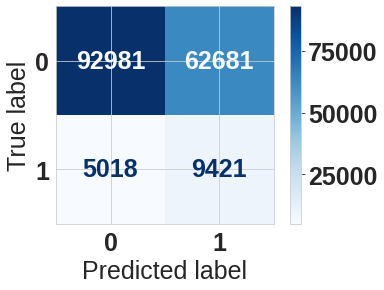

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

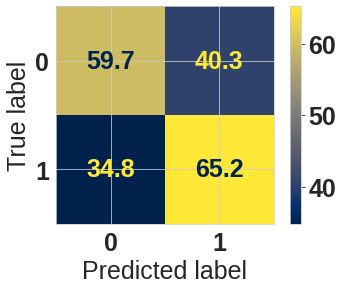

In [57]:
disp = ConfusionMatrixDisplay(np.array([[59.7, 40.3], [34.8, 65.2]]))
disp.plot(cmap=plt.cm.cividis,values_format='g')
plt.show()

In [145]:
cm

array([[92981, 62681],
       [ 5018,  9421]])

In [92]:
folds = 5

kf = KFold(n_splits=folds, shuffle=True, random_state=22)
roc_auc_kf = []
precision_kf = []
recall_kf = []
accuracy_kf = []

for bigger_part, smaller_part in kf.split(X_test):
    cur_true = y_test.iloc[smaller_part]
    cur_pred = model_lgbm.predict(X_test.iloc[smaller_part]).round()
    roc_auc_kf.append(roc_auc_score(cur_true, model_lgbm.predict(X_test.iloc[smaller_part])))
    precision_kf.append(precision_score(cur_true, cur_pred))
    recall_kf.append(recall_score(cur_true, cur_pred))
    accuracy_kf.append(accuracy_score(cur_true, cur_pred))

print('5 folds testing:')
print()
print("ROC-AUC:")
print(f'\tMean :{round(sum(roc_auc_kf)/folds, 3)}')
print(f'\tMin  :{round(min(roc_auc_kf), 3)}')
print(f'\tMax  :{round(max(roc_auc_kf), 3)}')
print(f'\tDiff :{round(max(roc_auc_kf) - min(roc_auc_kf), 3)}')
print()
print('Precision:')
print(f'\tMean :{round(sum(precision_kf)/folds, 3)}')
print(f'\tMin  :{round(min(precision_kf), 3)}')
print(f'\tMax  :{round(max(precision_kf), 3)}')
print(f'\tDiff :{round(max(precision_kf) - min(precision_kf), 3)}')
print()
print('Recall:')
print(f'\tMean :{round(sum(recall_kf)/folds, 3)}')
print(f'\tMin  :{round(min(recall_kf), 3)}')
print(f'\tMax  :{round(max(recall_kf), 3)}')
print(f'\tDiff :{round(max(recall_kf) - min(recall_kf), 3)}')
print()
print('Accuracy:')
print(f'\tMean :{round(sum(accuracy_kf)/folds, 3)}')
print(f'\tMin  :{round(min(accuracy_kf), 3)}')
print(f'\tMax  :{round(max(accuracy_kf), 3)}')
print(f'\tDiff :{round(max(accuracy_kf) - min(accuracy_kf), 3)}')
print()

5 folds testing:

ROC-AUC:
	Mean :0.671
	Min  :0.663
	Max  :0.681
	Diff :0.018

Precision:
	Mean :0.131
	Min  :0.125
	Max  :0.136
	Diff :0.011

Recall:
	Mean :0.652
	Min  :0.64
	Max  :0.661
	Diff :0.021

Accuracy:
	Mean :0.602
	Min  :0.6
	Max  :0.606
	Diff :0.006



In [74]:
sum([1, 2])/2

1.5

In [33]:
for i in cm:
    print(i)

[92981 62681]
[5018 9421]


In [29]:
def tune_weight(pred, true_border=0.5):
    res = []
    for num in pred:
        int_num = 1 if num >= true_border else 0
        res.append(int_num)
    return res

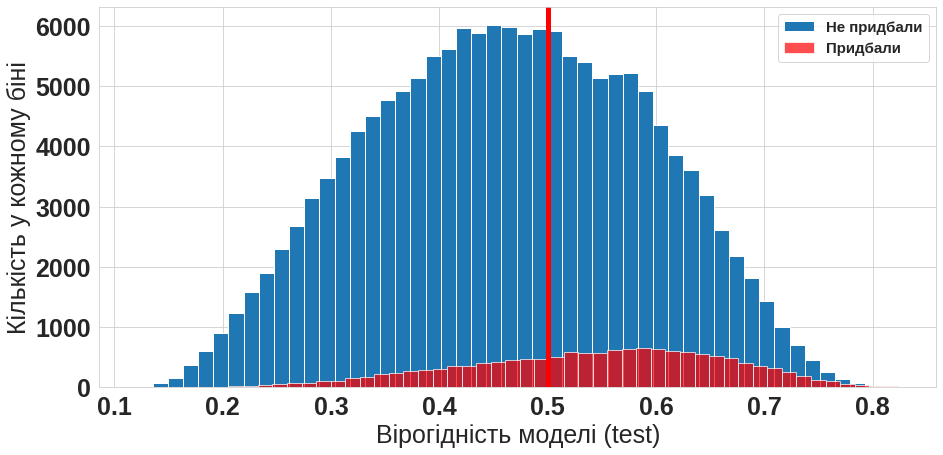

In [136]:
plt.figure(figsize=(15,7))
plt.hist(pred[y_test==0], bins=50, label='Не придбали')
plt.hist(pred[y_test==1], bins=50, label='Придбали', alpha=0.7, color='r')
plt.xlabel('Вірогідність моделі (test)', fontsize=25)
plt.ylabel('Кількість у кожному біні', fontsize=25)
plt.legend(fontsize=15)
plt.axvline(0.5, linewidth=5., color='r')
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

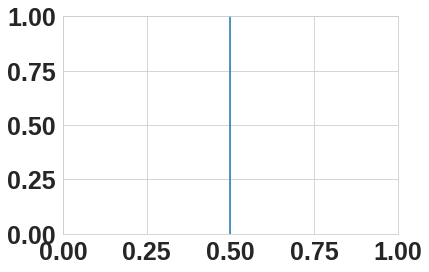

In [119]:
y_test.value_counts()
plt.axvline(0.5)

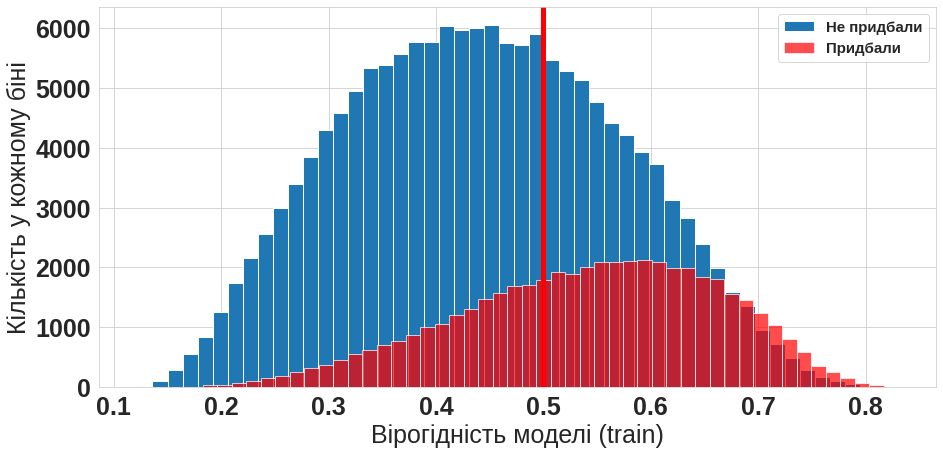

In [135]:
plt.figure(figsize=(15,7))
plt.hist(model_lgbm.predict(X_train)[y_train==0], bins=50, label='Не придбали')
plt.hist(model_lgbm.predict(X_train)[y_train==1], bins=50, label='Придбали', alpha=0.7, color='r')
plt.xlabel('Вірогідність моделі (train)', fontsize=25)
plt.ylabel('Кількість у кожному біні', fontsize=25)
plt.legend(fontsize=15)
plt.axvline(0.5, linewidth=5., color='r')
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [110]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler()
X_us_test, y_us_test = us.fit_resample(X_test, y_test)

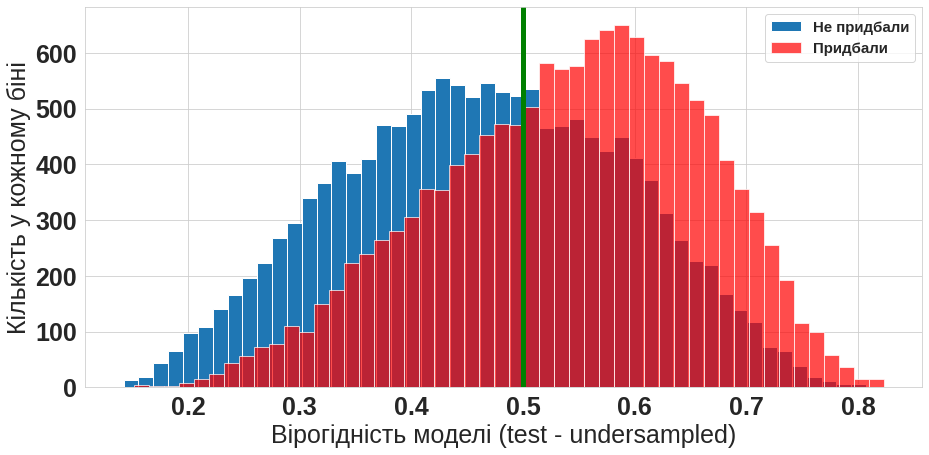

In [133]:
plt.figure(figsize=(15,7))
plt.hist(model_lgbm.predict(X_us_test)[y_us_test==0], bins=50, label='Не придбали')
plt.hist(model_lgbm.predict(X_us_test)[y_us_test==1], bins=50, label='Придбали', alpha=0.7, color='r')
plt.xlabel('Вірогідність моделі (test - undersampled)', fontsize=25)
plt.ylabel('Кількість у кожному біні', fontsize=25)
plt.legend(fontsize=15)
plt.axvline(0.5, linewidth=5., color='g')
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

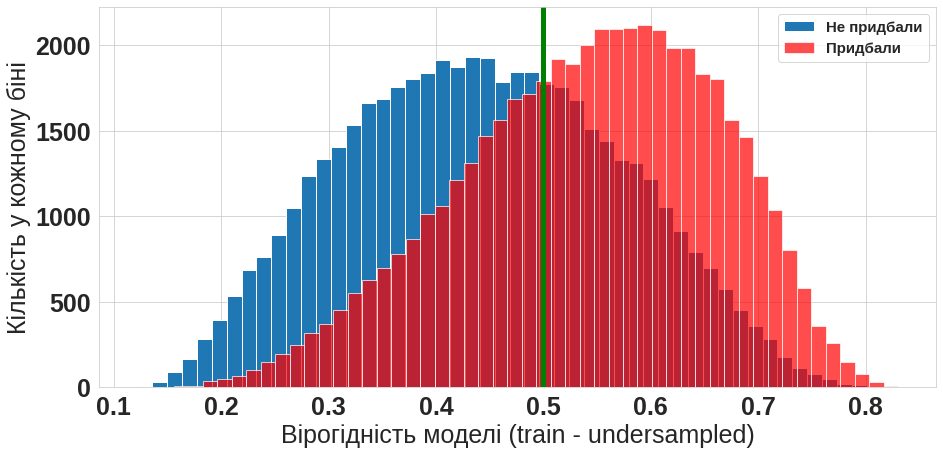

In [132]:
X_us_train, y_us_train = us.fit_resample(X_train, y_train)
plt.figure(figsize=(15,7))
plt.hist(model_lgbm.predict(X_us_train)[y_us_train==0], bins=50, label='Не придбали')
plt.hist(model_lgbm.predict(X_us_train)[y_us_train==1], bins=50, label='Придбали', alpha=0.7, color='r')
plt.xlabel('Вірогідність моделі (train - undersampled)', fontsize=25)
plt.ylabel('Кількість у кожному біні', fontsize=25)
plt.axvline(0.5, linewidth=5., color='g')
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [138]:
pred_un = model_lgbm.predict(X_us_test)

In [144]:
confusion_matrix(y_us_test, pred_un.round())

array([[8667, 5772],
       [5018, 9421]])

In [142]:
y_us_test.value_counts()

0.0    14439
1.0    14439
Name: target, dtype: int64

In [210]:
values_total = 14439
x_pos = []
another_val = []
target_val = []

for tresh in np.arange(0, 1, 0.01):
    cur_pred = tune_weight(pred_un, true_border=tresh)
    another = confusion_matrix(y_us_test, cur_pred)[0][1]
    target = confusion_matrix(y_us_test, cur_pred)[1][1]
    x_pos.append(tresh)
    another_val.append((another/values_total)*100)
    target_val.append((target/values_total)*100)

In [216]:
cur_pred = tune_weight(pred_un, true_border=0.4)
#confusion_matrix(y_us_test, cur_pred)[1][0]
confusion_matrix(y_us_test, cur_pred)[1][1]/values_total

0.8619710506267747

(0.2, 0.8)

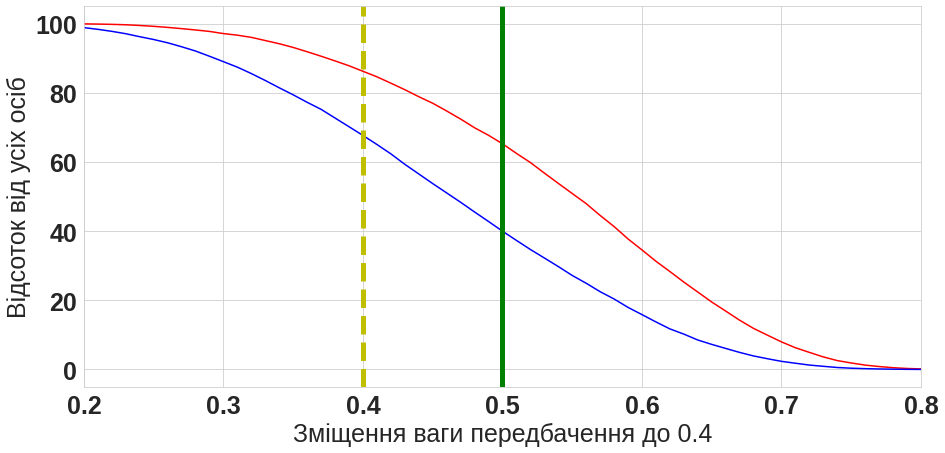

In [212]:
plt.figure(figsize=(15,7))
plt.plot(x_pos,target_val, color='r')
plt.plot(x_pos,another_val, color='b')
plt.axvline(0.5, color='g', linewidth=5.)
plt.axvline(0.4, color='y', linestyle='dashed', linewidth=5.)
plt.xlabel("Зміщення ваги передбачення до 0.4")
plt.ylabel("Відсоток від усіх осіб")
plt.xlim(0.2, 0.8)

